In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
import seaborn as sns
from collections import Counter
import re
import numpy as np
import os
from scipy.interpolate import make_interp_spline
import scipy.stats as stats

In [3]:
file_path = "DataFrames\\anime_data.csv"

# Чтение CSV-файла в DataFrame
df = pd.read_csv(file_path)

# Вывод первых строк DataFrame для проверки
print(df.head())

   members  rating  anime_id  adult_score   ranked  popularity image_is_adult  \
0       75     NaN     45376          NaN  13696.0       23480            NaN   
1       50     NaN     45786          NaN  13729.0       25658            NaN   
2      600     NaN     44228          NaN  20311.0       15040            NaN   
3       92     NaN     44463          NaN  13693.0       22387            NaN   
4      279     NaN     53055          NaN  20314.0       18602            NaN   

   set       description_vector     id  ... season  \
0    0  <memory at 0x108a61180>  13796  ...   2007   
1    0  <memory at 0x108a634c0>  13829  ...   2013   
2    0  <memory at 0x108a63580>  20411  ...   2020   
3    0  <memory at 0x108a63700>  13793  ...   2011   
4    0  <memory at 0x108a63880>  20414  ...   2022   

                                         description  \
0  No synopsis information has been added to this...   
1  No synopsis information has been added to this...   
2  No synopsis infor

In [4]:
print(df.columns)

Index(['members', 'rating', 'anime_id', 'adult_score', 'ranked', 'popularity',
       'image_is_adult', 'set', 'description_vector', 'id', 'image0',
       'description_ru', 'scenario_ru', 'poster_ru', 'translation_type',
       'title_orig', 'title_en', 'title_ru', 'image_link', 'image5', 'image6',
       'is_adult', 'image_adult_reason', 'genres', 'predicted_genres',
       'season', 'description', 'url', 'title', 'scenario', 'poster', 'image1',
       'image2', 'image3', 'image4'],
      dtype='object')


In [5]:
df['season'] = df['season'].str.replace(r'\D', '', regex=True)

# Преобразуем оставшиеся значения к числовому типу (если нужно)
df['season'] = pd.to_numeric(df['season'], errors='coerce')

In [6]:
#Выбираем нужные для анализа столбцы
df_selected = df[['members', 'rating', 'ranked', 'popularity', 'title_orig', 'genres', 'description', 'season']]

In [7]:
print(df_selected.head())

   members  rating   ranked  popularity  \
0       75     NaN  13696.0       23480   
1       50     NaN  13729.0       25658   
2      600     NaN  20311.0       15040   
3       92     NaN  13693.0       22387   
4      279     NaN  20314.0       18602   

                                          title_orig  \
0                                    Tian Yanshen Hu   
1                                    Tico Xiaji Pian   
2  Jian Wang 3: Xia Gan Yi Dan Shen Jianxin Zhi C...   
3                    Tian Xin Ge Ge: Henian Duanpian   
4         Jian Yu Yuanzheng: Insomnia De Naxie Shier   

                        genres  \
0                Fantasy, Kids   
1                         Kids   
2           Comedy, Historical   
3                         Kids   
4  Comedy, Fantasy, Video Game   

                                         description  season  
0  No synopsis information has been added to this...  2007.0  
1  No synopsis information has been added to this...  2013.0  
2  No syno

In [8]:
df_cl = df_selected.dropna() #убираем все строки, которые содержат пустые значения
df_cleaned = df_cl[df_cl['description'].str.len() > 500] #оставляем только те строки, в которых описание фильмов длиннее 500 символов

In [9]:
print(df_cleaned.head())

     members  rating  ranked  popularity                     title_orig  \
371    28615    7.26  2843.0        4093           Kyouran Kazoku Nikki   
383   415221    7.62  1413.0         549           Free! Eternal Summer   
386    17780    6.25  8046.0        5036                   Loups=Garous   
392    67989    7.62  1394.0        2593                  Piano no Mori   
393   214321    7.76  1048.0        1111  Kumichou Musume to Sewagakari   

                           genres  \
371                Comedy, Sci-Fi   
383                        School   
386               Mystery, Sci-Fi   
392  Drama, Music, School, Seinen   
393                 Slice of Life   

                                           description  season  
371  Midarezaki Ouka is used to having strange thin...  2008.0  
383  Even though it has been a year since the Iwato...  2014.0  
386  In a future governed through the lens of a cam...  2010.0  
392  Piano no Mori  tells the story of Shuuhei Amam...  2007.0  
3

In [10]:
print(df_cleaned.info()) #смотрим информацию по всем столбцам, проверяем, что нет пустых значений

<class 'pandas.core.frame.DataFrame'>
Index: 5407 entries, 371 to 25749
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   members      5407 non-null   int64  
 1   rating       5407 non-null   float64
 2   ranked       5407 non-null   float64
 3   popularity   5407 non-null   int64  
 4   title_orig   5407 non-null   object 
 5   genres       5407 non-null   object 
 6   description  5407 non-null   object 
 7   season       5407 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 380.2+ KB
None


In [11]:
print(df_cleaned.columns)

Index(['members', 'rating', 'ranked', 'popularity', 'title_orig', 'genres',
       'description', 'season'],
      dtype='object')


In [12]:
df_cleaned.columns.values[-1] = 'year'

In [13]:
print(df_cleaned.columns)

Index(['members', 'rating', 'ranked', 'popularity', 'title_orig', 'genres',
       'description', 'year'],
      dtype='object')


In [14]:
#Считаем и выводим основные показатели по рейтингу - главному показателю, интересующему нас в анализе
m = df_cleaned['rating'].mean()
med = df_cleaned['rating'].median()
mod = df_cleaned['rating'].mode()
stdrt = df_cleaned['rating'].std()
print(f'Mean rating: {round(m, 2)}')
print(f'Median rating: {round(med, 2)}')
print(f'Mod rating: {round(mod, 2)}')
print(f'Standart deviation: {round(stdrt, 2)}')

Mean rating: 6.93
Median rating: 7.02
Mod rating: 0    7.16
Name: rating, dtype: float64
Standart deviation: 0.87


Гипотеза1
Распределение оценок пользователей примерно соответствует нормальному распределению

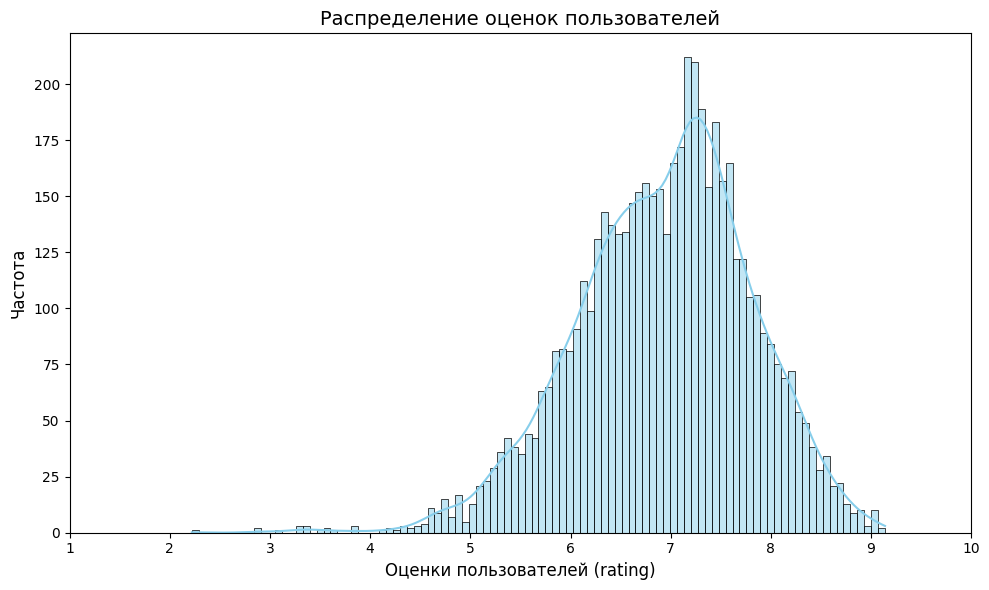

In [15]:
# Настройка графика
plt.figure(figsize=(10, 6))

# Построение распределения оценок
sns.histplot(df_cleaned['rating'], bins=100, kde=True, color='skyblue', edgecolor='black')

# Настройка осей
plt.xlabel('Оценки пользователей (rating)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.title('Распределение оценок пользователей', fontsize=14)

# Настройка оси X для отображения с точностью до сотых
plt.xticks(ticks=[round(x, 2) for x in plt.xticks()[0]])

# Показываем график
plt.tight_layout()
plt.show()

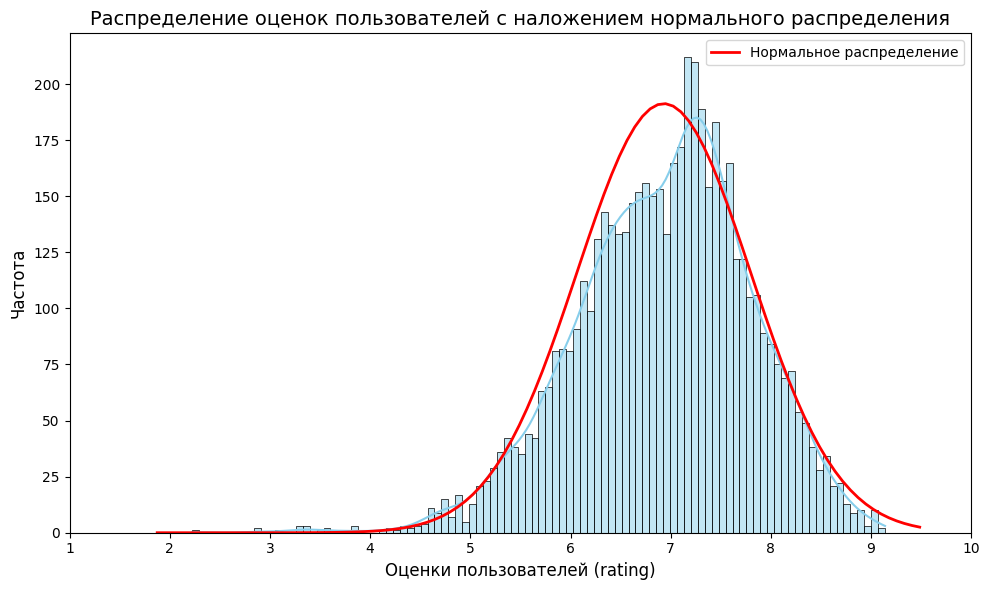

In [16]:
#Накладываем график нормального распределения с наиболее близкими к нашему графику параметрами

# Настройка графика
plt.figure(figsize=(10, 6))

# Построение распределения оценок с KDE
sns.histplot(df_cleaned['rating'], bins=100, kde=True, color='skyblue', edgecolor='black')

# Вычисляем среднее и стандартное отклонение для нормального распределения
mean = df_cleaned['rating'].mean()
std_dev = df_cleaned['rating'].std()

# Создаем диапазон значений для графика нормального распределения
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Строим теоретическое нормальное распределение
p = stats.norm.pdf(x, mean, std_dev)

# Наложение нормального распределения на гистограмму
plt.plot(x, p * len(df_cleaned) * (x[1] - x[0]), 'r-', label='Нормальное распределение', lw=2)

# Настройка осей
plt.xlabel('Оценки пользователей (rating)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.title('Распределение оценок пользователей с наложением нормального распределения', fontsize=14)

# Настройка оси X для отображения с точностью до сотых
plt.xticks(ticks=[round(x, 2) for x in plt.xticks()[0]])

# Добавляем легенду
plt.legend()

# Показываем график
plt.tight_layout()
plt.show()

Для фильмов с более высоким рейтингом, как правило, характерно более длинное описание (synopsis)

C:\Users\andre\AppData\Local\Temp\ipykernel_14012\3204443569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['description'] = df_cleaned['description'].astype(str)
C:\Users\andre\AppData\Local\Temp\ipykernel_14012\3204443569.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['description_length'] = df_cleaned['description'].apply(len)


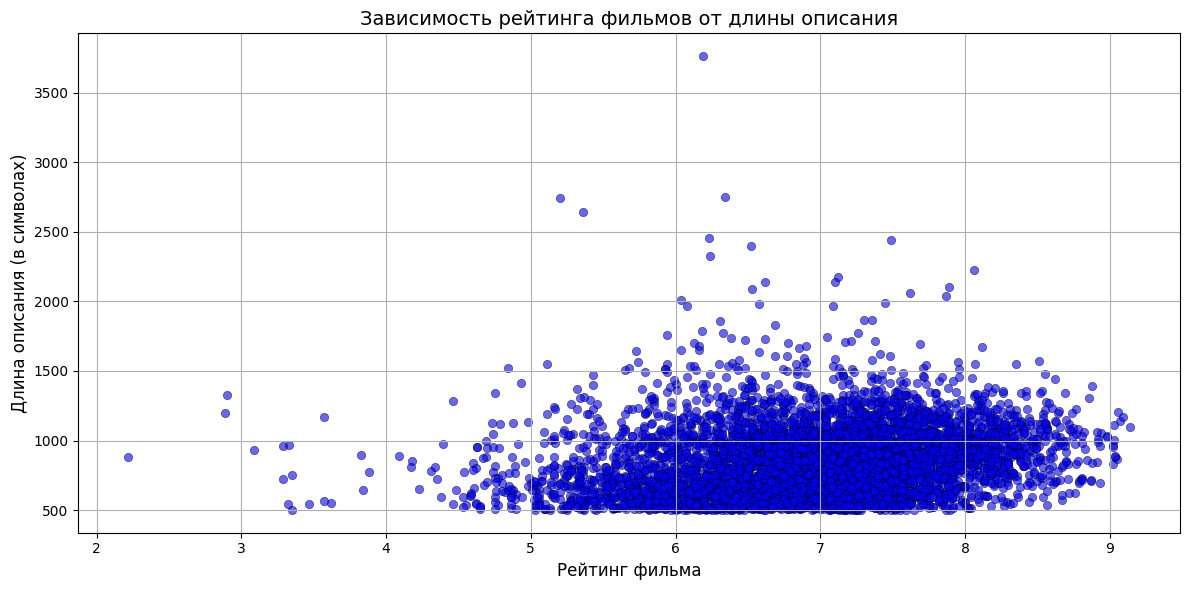

In [17]:
# Убедимся, что столбец 'description' содержит строки
df_cleaned['description'] = df_cleaned['description'].astype(str)

# Добавляем столбец с длиной описания
df_cleaned['description_length'] = df_cleaned['description'].apply(len)

# Построение графика
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_cleaned, x='rating', y='description_length', alpha=0.6, color='blue', edgecolor='black')

# Настройка графика
plt.title('Зависимость рейтинга фильмов от длины описания', fontsize=14)
plt.xlabel('Рейтинг фильма', fontsize=12)
plt.ylabel('Длина описания (в символах)', fontsize=12)
plt.grid(True)

# Показываем график
plt.tight_layout()
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_14012\1702707139.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['description'] = df_cleaned['description'].astype(str)
C:\Users\andre\AppData\Local\Temp\ipykernel_14012\1702707139.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['description_length'] = df_cleaned['description'].apply(len)


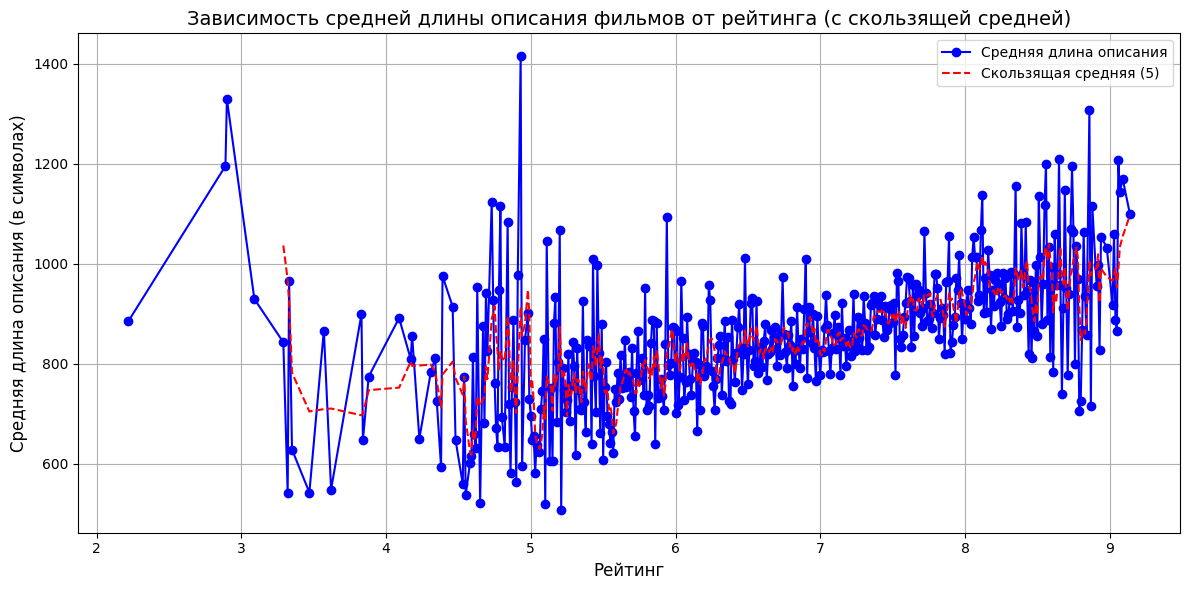

In [18]:
#Для более наглядной визуализации используем скользящее среднее для средней длины описаний при определённом рейтинге

# Убедимся, что столбец 'description' содержит строки
df_cleaned['description'] = df_cleaned['description'].astype(str)

# Добавляем столбец с длиной описания
df_cleaned['description_length'] = df_cleaned['description'].apply(len)

# Группируем данные по рейтингу и вычисляем среднюю длину описания
average_description_length = df_cleaned.groupby('rating')['description_length'].mean().reset_index()

# Округляем длину описания до сотых
average_description_length['description_length'] = average_description_length['description_length'].round(2)

# Применяем скользящую среднюю (окно = 5)
average_description_length['smoothed_description_length'] = average_description_length['description_length'].rolling(window=5).mean()

# Построение графика
plt.figure(figsize=(12, 6))

# Линия для средней длины описания
plt.plot(average_description_length['rating'], average_description_length['description_length'], color='blue', marker='o', label='Средняя длина описания')

# Линия для скользящей средней
plt.plot(average_description_length['rating'], average_description_length['smoothed_description_length'], color='red', linestyle='--', label='Скользящая средняя (5)')

# Настройка графика
plt.title('Зависимость средней длины описания фильмов от рейтинга (с скользящей средней)', fontsize=14)
plt.xlabel('Рейтинг', fontsize=12)
plt.ylabel('Средняя длина описания (в символах)', fontsize=12)
plt.grid(True)
plt.legend()

# Показываем график
plt.tight_layout()
plt.show()

Количество пользователей (members) фильма и его рейтинг не зависят друг от друга

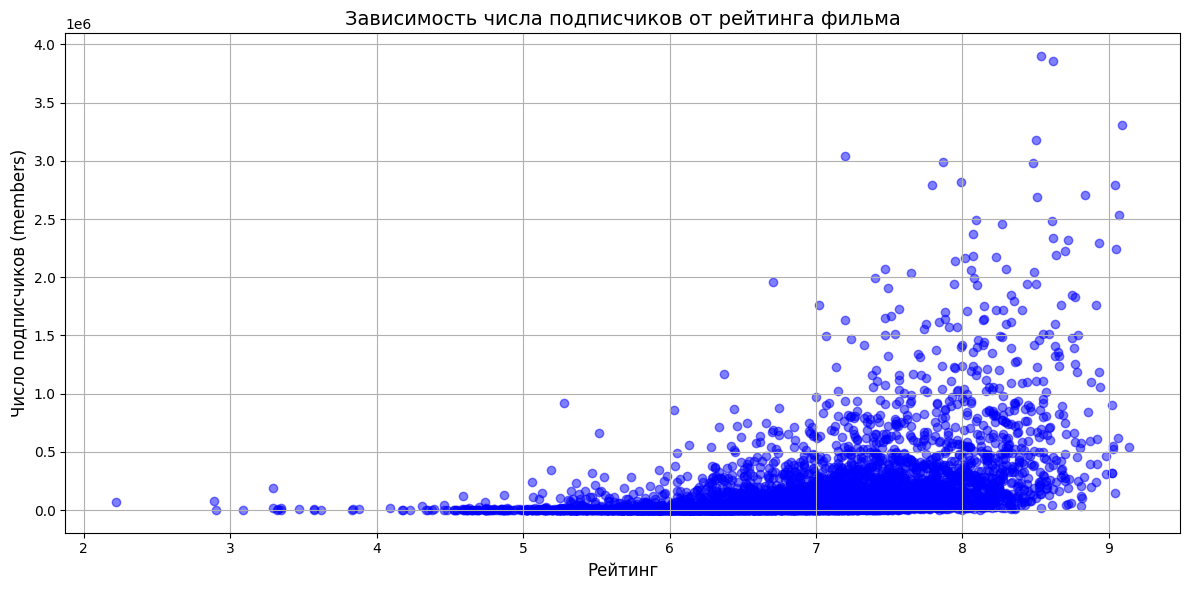

In [19]:
plt.figure(figsize=(12, 6))

# Используем scatter plot для отображения точек
plt.scatter(df_cleaned['rating'], df_cleaned['members'], color='blue', alpha=0.5)

# Настройка графика
plt.title('Зависимость числа подписчиков от рейтинга фильма', fontsize=14)
plt.xlabel('Рейтинг', fontsize=12)
plt.ylabel('Число подписчиков (members)', fontsize=12)
plt.grid(True)

# Показываем график
plt.tight_layout()
plt.show()

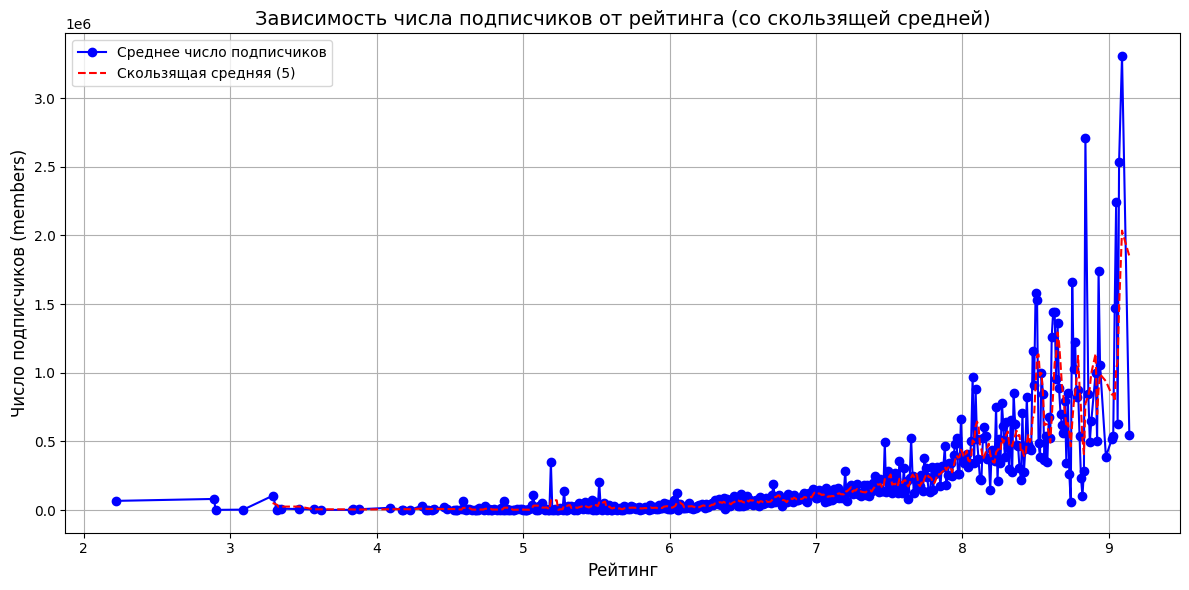

In [20]:
# Группируем данные по рейтингу и вычисляем среднее число подписчиков для каждого рейтинга
average_members = df_cleaned.groupby('rating')['members'].mean().reset_index()

# Округляем количество подписчиков до сотых
average_members['members'] = average_members['members'].round(2)

# Применяем скользящую среднюю (окно = 5)
average_members['smoothed_members'] = average_members['members'].rolling(window=5).mean()

# Построение графика
plt.figure(figsize=(12, 6))

# Линия для среднего числа подписчиков
plt.plot(average_members['rating'], average_members['members'], color='blue', marker='o', label='Среднее число подписчиков')

# Линия для скользящей средней
plt.plot(average_members['rating'], average_members['smoothed_members'], color='red', linestyle='--', label='Скользящая средняя (5)')

# Настройка графика
plt.title('Зависимость числа подписчиков от рейтинга (со скользящей средней)', fontsize=14)
plt.xlabel('Рейтинг', fontsize=12)
plt.ylabel('Число подписчиков (members)', fontsize=12)
plt.grid(True)
plt.legend()

# Показываем график
plt.tight_layout()
plt.show()

более новые аниме имеют рейтинг ниже

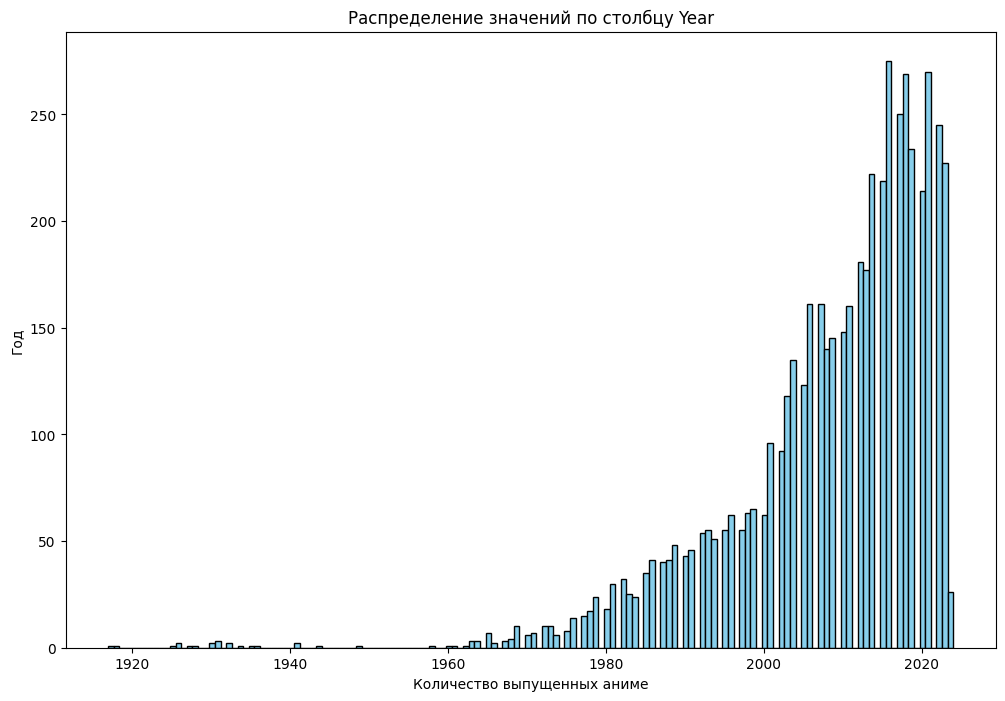

In [21]:
plt.figure(figsize=(12, 8))
df_cleaned['year'].hist(bins=150, color='skyblue', edgecolor='black')

# Настройка графика
plt.title('Распределение значений по столбцу Year')
plt.xlabel('Количество выпущенных аниме')
plt.ylabel('Год')
plt.grid(False)
plt.show()

In [23]:
year_counts = df_cleaned['year'].value_counts()

# 2. Сортируем по убыванию
year_counts_sorted = year_counts.sort_values(ascending=False)

# 3. Выводим результат
print(year_counts_sorted)

year
2016.0    275
2021.0    270
2018.0    269
2017.0    250
2022.0    245
         ... 
1934.0      1
1925.0      1
1962.0      1
1961.0      1
1927.0      1
Name: count, Length: 81, dtype: int64


In [25]:
threshold = 1950 
df_old = df_cleaned[df_cleaned['year'] < threshold]

In [26]:
print(df_old.head())

      members  rating   ranked  popularity                       title_orig  \
3522      500    5.23  12058.0       15803                   Kyoudai Koguma   
3752     1344    4.73  12751.0       12257                  Hanasaka Jiisan   
5549      715    4.89  12580.0       14413           Kitsune no Home Run Ou   
6469      911    4.82  12656.0       13571           Fuku-chan no Sensuikan   
6628     2978    4.68  12787.0        9867  Urashima Tarou (supposed title)   

                  genres                                        description  \
3522           Adventure  Spring—birds are singing, frogs are dancing. A...   
3752       Comedy, Drama  A short movie produced by Yasuji Murata. Based...   
5549                Kids  Two animal baseball teams, The Foxes and The R...   
6469  Comedy, Historical  Fuku-chan was one of the most popular newspape...   
6628          Historical  Urashima Tarou is based on a well-known Japane...   

        year  description_length  
3522  1932.0   

In [27]:
print(df_cleaned['genres'].unique())
print(df_cleaned['genres'].head())

['Comedy, Sci-Fi' 'School' 'Mystery, Sci-Fi' ...
 'Drama, Historical, Seinen, Supernatural'
 'Music, Mystery, Romance, School' 'Drama, Fantasy, Mystery, Supernatural']
371                  Comedy, Sci-Fi
383                          School
386                 Mystery, Sci-Fi
392    Drama, Music, School, Seinen
393                   Slice of Life
Name: genres, dtype: object


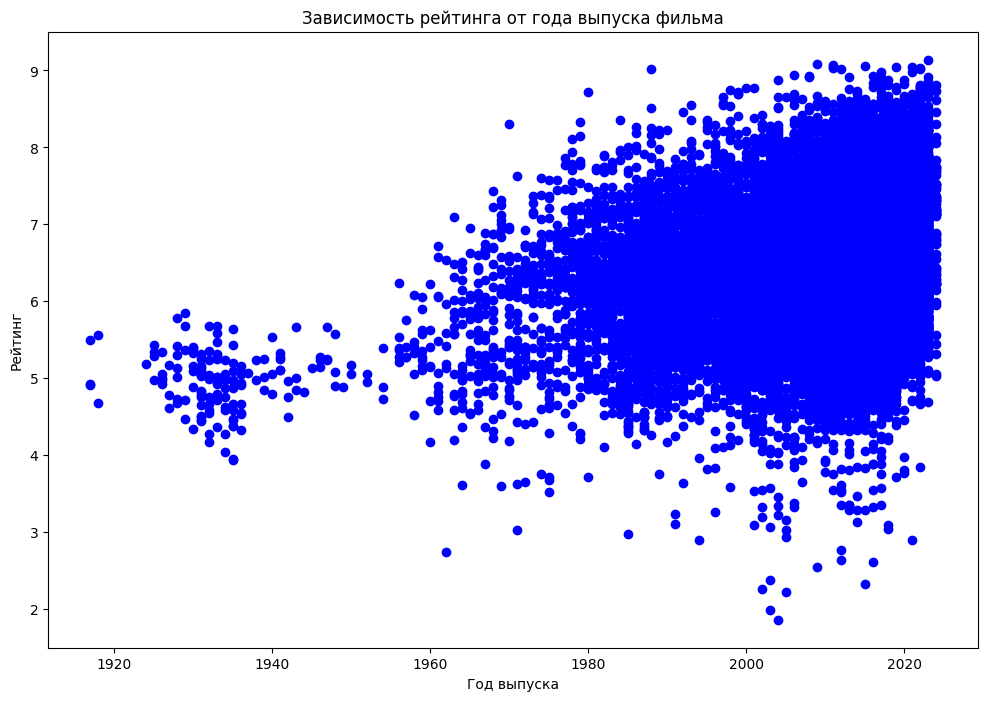

In [28]:
# Построение диаграммы рассеяния (scatter plot)
plt.figure(figsize=(12,8))
plt.scatter(df['season'], df['rating'], color='blue')

# Добавляем подписи и заголовок
plt.title('Зависимость рейтинга от года выпуска фильма')
plt.xlabel('Год выпуска')
plt.ylabel('Рейтинг')

# Показать график
plt.show()

In [30]:
df_avg = df_cleaned.groupby('year')['rating'].mean().reset_index()

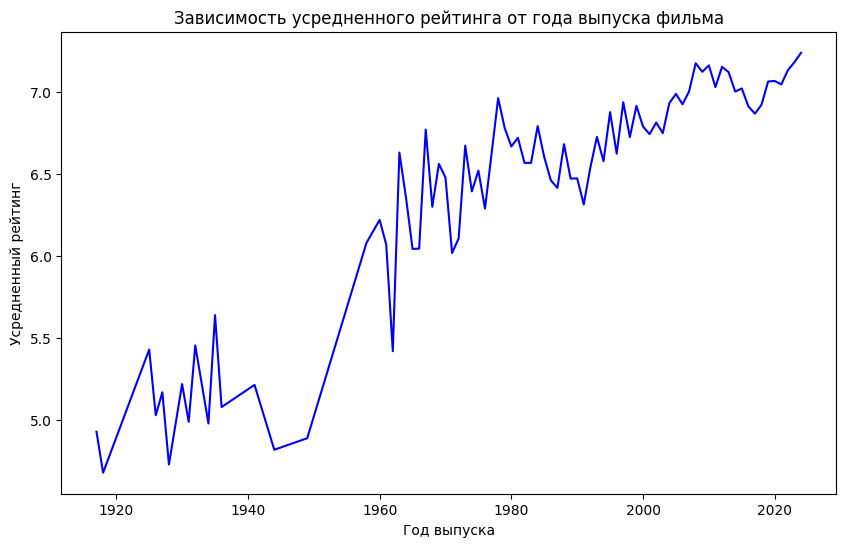

In [31]:
plt.figure(figsize=(10,6))

# Используем seaborn для построения линейного графика
sns.lineplot(x='year', y='rating', data=df_avg, color='blue')

# Добавляем подписи и заголовок
plt.title('Зависимость усредненного рейтинга от года выпуска фильма')
plt.xlabel('Год выпуска')
plt.ylabel('Усредненный рейтинг')

# Показать график
plt.show()

In [32]:
def extract_unique_words(genre_string):
    # Разбиваем строку на слова, удаляя лишние символы (запятые, скобки и т.д.)
    words = re.findall(r'\w+', genre_string.lower())  # .lower() для унификации, чтобы не было различий между большими и маленькими буквами
    return words

# Применяем функцию для всех значений в столбце 'genres'
all_words = df_cleaned['genres'].apply(extract_unique_words).explode().unique()

# Выводим все уникальные слова
print("Уникальные слова в жанрах и возрастных категориях:")
print(all_words)

Уникальные слова в жанрах и возрастных категориях:
['comedy' 'sci' 'fi' 'school' 'mystery' 'drama' 'music' 'seinen' 'slice'
 'of' 'life' 'ecchi' 'fantasy' 'romance' 'shounen' 'action' 'adventure'
 'mecha' 'historical' 'supernatural' 'kids' 'pets' 'josei' 'sports'
 'parody' 'visual' 'arts' 'performing' 'super' 'power' 'strategy' 'game'
 'racing' 'cgdct' 'iyashikei' 'award' 'winning' 'team' 'adult' 'cast'
 'psychological' 'harem' 'isekai' 'reincarnation' 'avant' 'garde'
 'military' 'detective' 'workplace']


In [33]:
GENRE_LIST = ["Action", "Adventure", "Comedy", "Drama", "Ecchi", "Fantasy", "Hentai", "Historical", "Mecha",
 "Music", "Mystery", "Romance", "School", "Sci-Fi", "Slice of Life", "Supernatural"]
DEMOGRAPHIC = ['Josei', 'Kids', 'Seinen', 'Shoujo', 'Shounen']

C:\Users\andre\AppData\Local\Temp\ipykernel_14012\2701720659.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[genre] = df_cleaned['genres'].apply(lambda x: genre_in_list(x, genre))
C:\Users\andre\AppData\Local\Temp\ipykernel_14012\2701720659.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[genre] = df_cleaned['genres'].apply(lambda x: genre_in_list(x, genre))
C:\Users\andre\AppData\Local\Temp\ipykernel_14012\2701720659.py:6: SettingWithCopyWarning: 
A value is trying to be set on

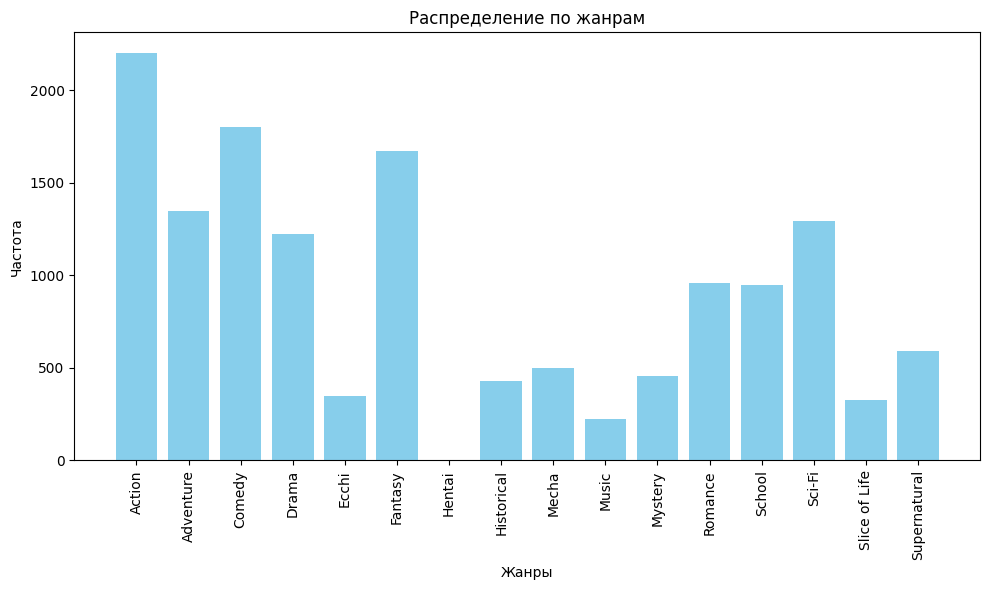

In [34]:
def genre_in_list(row, genre):
    return 1 if genre in row else 0

# Применяем функцию для каждого жанра из GENRE_LIST
for genre in GENRE_LIST:
    df_cleaned[genre] = df_cleaned['genres'].apply(lambda x: genre_in_list(x, genre))

# Подсчитываем, сколько раз каждый жанр встречается
genre_counts = df_cleaned[GENRE_LIST].sum()

# Строим гистограмму для жанров
plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values, color='skyblue')
plt.title('Распределение по жанрам')
plt.xlabel('Жанры')
plt.ylabel('Частота')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_14012\1771477933.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[dem] = df_cleaned['genres'].apply(lambda x: dem_in_list(x, dem))
C:\Users\andre\AppData\Local\Temp\ipykernel_14012\1771477933.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[dem] = df_cleaned['genres'].apply(lambda x: dem_in_list(x, dem))
C:\Users\andre\AppData\Local\Temp\ipykernel_14012\1771477933.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

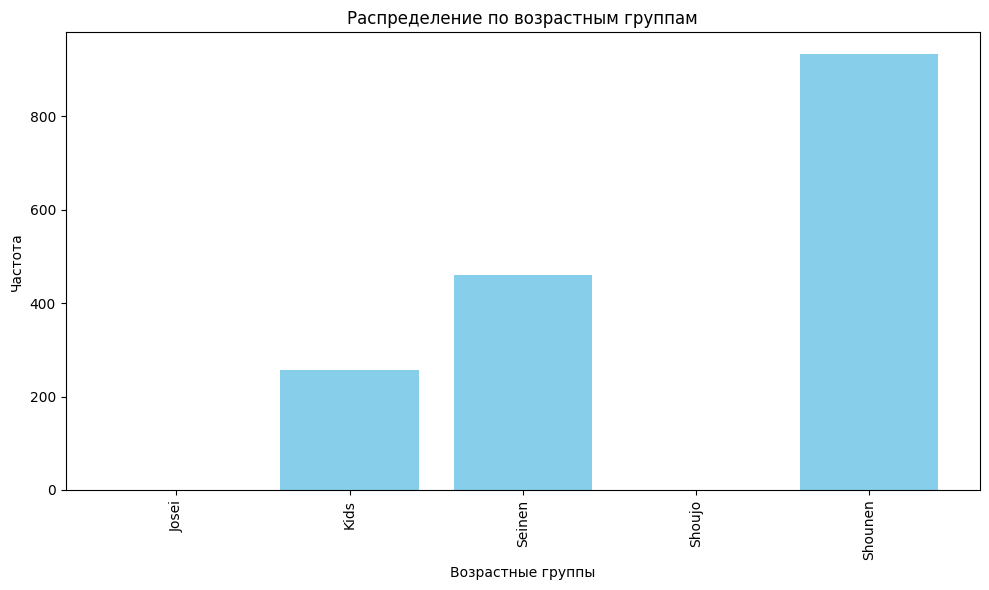

In [35]:
def dem_in_list(row, dem):
    return 1 if dem in row else 0

# Применяем функцию для каждого жанра из GENRE_LIST
for dem in DEMOGRAPHIC:
    df_cleaned[dem] = df_cleaned['genres'].apply(lambda x: dem_in_list(x, dem))

# Подсчитываем, сколько раз каждый жанр встречается
dem_counts = df_cleaned[DEMOGRAPHIC].sum()

# Строим гистограмму для жанров
plt.figure(figsize=(10, 6))
plt.bar(dem_counts.index, dem_counts.values, color='skyblue')
plt.title('Распределение по возрастным группам')
plt.xlabel('Возрастные группы')
plt.ylabel('Частота')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [36]:
for dem in DEMOGRAPHIC:
    df_cleaned[dem] = df_cleaned['genres'].apply(lambda x: 1 if dem in x else 0)

# Подсчитываем количество вхождений для каждой категории
dem_counts = df_cleaned[DEMOGRAPHIC].sum()

# Вывод распределения
print("Распределение по демографическим категориям:")
print(dem_counts)

Распределение по демографическим категориям:
Josei        1
Kids       257
Seinen     461
Shoujo       0
Shounen    933
dtype: int64


C:\Users\andre\AppData\Local\Temp\ipykernel_14012\674551311.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[dem] = df_cleaned['genres'].apply(lambda x: 1 if dem in x else 0)


C:\Users\andre\AppData\Local\Temp\ipykernel_14012\3433927617.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[genre] = df_cleaned['genres'].apply(lambda x: genre_in_list(x, genre))


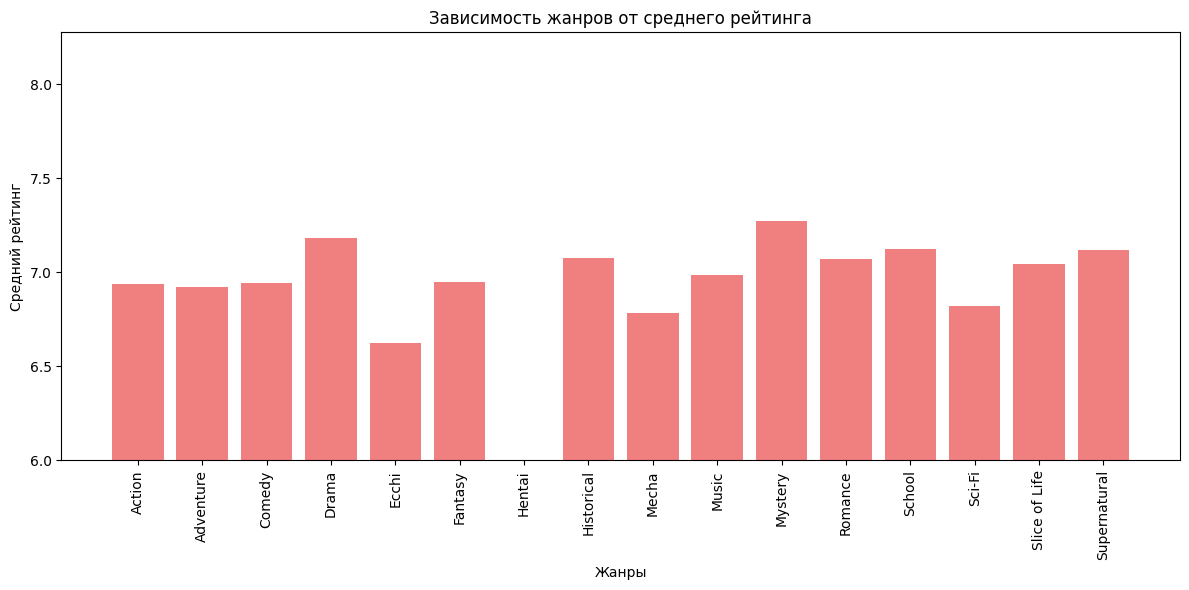

In [37]:
def genre_in_list(row, genre):
    return 1 if genre in row else 0

# Применяем функцию для каждого жанра из GENRE_LIST
for genre in GENRE_LIST:
    df_cleaned[genre] = df_cleaned['genres'].apply(lambda x: genre_in_list(x, genre))

# Для каждого жанра вычисляем средний рейтинг
genre_avg_ratings = df_cleaned[GENRE_LIST].multiply(df_cleaned['rating'], axis=0).sum() / df_cleaned[GENRE_LIST].sum()

# Строим график зависимости жанра от среднего рейтинга
plt.figure(figsize=(12, 6))
plt.bar(genre_avg_ratings.index, genre_avg_ratings.values, color='lightcoral')
plt.title('Зависимость жанров от среднего рейтинга')
plt.xlabel('Жанры')
plt.ylabel('Средний рейтинг')
plt.ylim(6, genre_avg_ratings.max() + 1)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_14012\1932227274.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[genre] = df_cleaned['genres'].apply(lambda x: count_genre(x, genre))


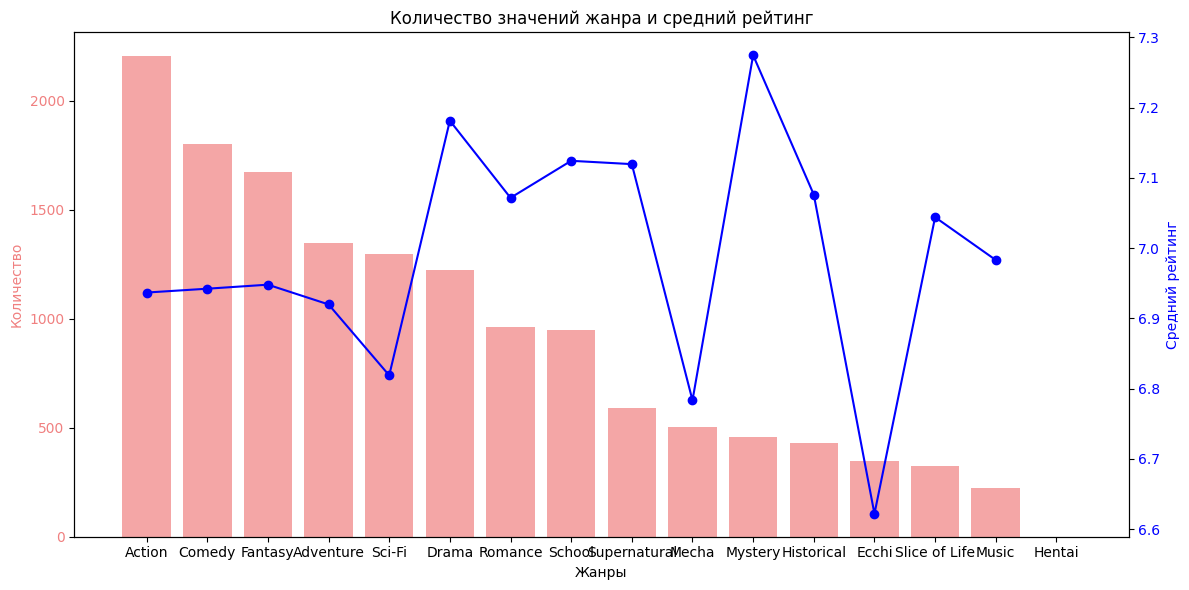

In [38]:
def count_genre(row, genre):
    return 1 if genre in row else 0

# Применяем функцию для каждого жанра из GENRE_LIST
for genre in GENRE_LIST:
    df_cleaned[genre] = df_cleaned['genres'].apply(lambda x: count_genre(x, genre))

# 1. Подсчитываем количество значений для каждого жанра
genre_counts = df_cleaned[GENRE_LIST].sum()

# 2. Рассчитываем средний рейтинг для каждого жанра
genre_avg_ratings = df_cleaned[GENRE_LIST].multiply(df_cleaned['rating'], axis=0).sum() / genre_counts

# Создаем DataFrame для удобства отображения
genre_stats = pd.DataFrame({
    'count': genre_counts,
    'avg_rating': genre_avg_ratings
}).sort_values(by='count', ascending=False)

# Строим график с двумя осями Y
fig, ax1 = plt.subplots(figsize=(12, 6))

# Гистограмма для количества жанров
ax1.bar(genre_stats.index, genre_stats['count'], color='lightcoral', label='Количество', alpha=0.7)
ax1.set_xlabel('Жанры')
ax1.set_ylabel('Количество', color='lightcoral')
ax1.tick_params(axis='y', labelcolor='lightcoral')

# Создаем вторую ось Y для среднего рейтинга
ax2 = ax1.twinx()
ax2.plot(genre_stats.index, genre_stats['avg_rating'], color='blue', marker='o', label='Средний рейтинг')
ax2.set_ylabel('Средний рейтинг', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Заголовок графика
plt.title('Количество значений жанра и средний рейтинг')

# Поворот подписей на оси X для удобства чтения
plt.xticks(rotation=90)

# Показываем график
plt.tight_layout()
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_14012\663408720.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[genre] = df_cleaned['genres'].apply(lambda x: count_genre(x, genre))


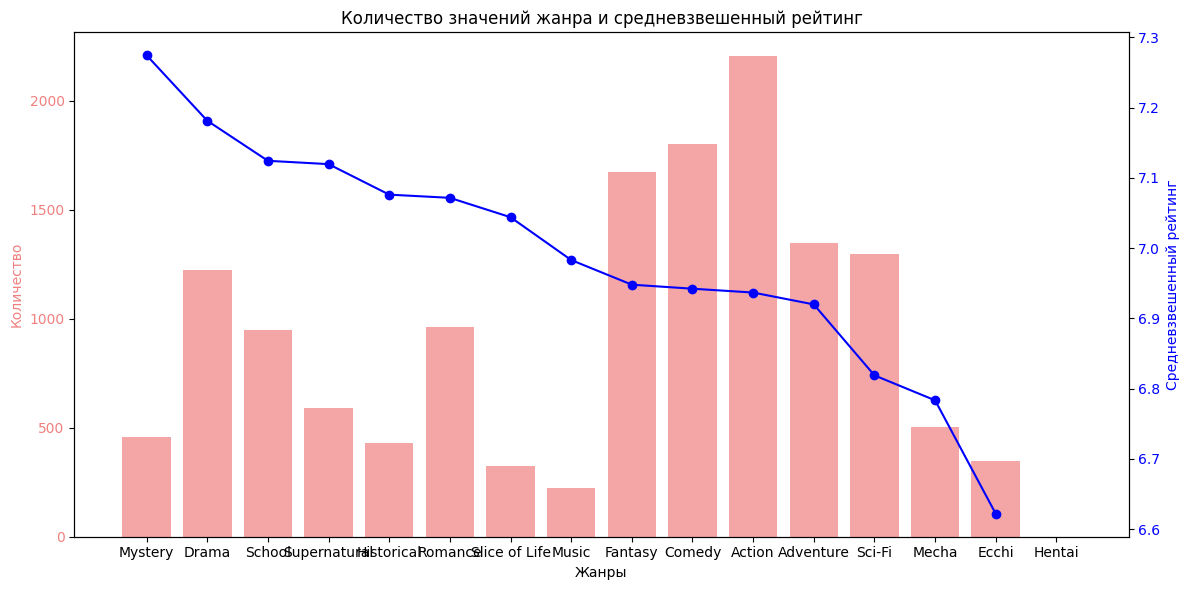

In [39]:
def count_genre(row, genre):
    return 1 if genre in row else 0

# Применяем функцию для каждого жанра из GENRE_LIST
for genre in GENRE_LIST:
    df_cleaned[genre] = df_cleaned['genres'].apply(lambda x: count_genre(x, genre))

# 1. Подсчитываем количество значений для каждого жанра
genre_counts = df_cleaned[GENRE_LIST].sum()

# 2. Рассчитываем **средневзвешенный рейтинг** для каждого жанра
genre_weighted_ratings = df_cleaned[GENRE_LIST].multiply(df_cleaned['rating'], axis=0).sum() / genre_counts

# Создаем DataFrame для удобства отображения
genre_stats = pd.DataFrame({
    'count': genre_counts,
    'weighted_avg_rating': genre_weighted_ratings
}).sort_values(by='weighted_avg_rating', ascending=False)

# Строим график с двумя осями Y
fig, ax1 = plt.subplots(figsize=(12, 6))

# Гистограмма для количества жанров
ax1.bar(genre_stats.index, genre_stats['count'], color='lightcoral', label='Количество', alpha=0.7)
ax1.set_xlabel('Жанры')
ax1.set_ylabel('Количество', color='lightcoral')
ax1.tick_params(axis='y', labelcolor='lightcoral')

# Создаем вторую ось Y для средневзвешенного рейтинга
ax2 = ax1.twinx()
ax2.plot(genre_stats.index, genre_stats['weighted_avg_rating'], color='blue', marker='o', label='Средневзвешенный рейтинг')
ax2.set_ylabel('Средневзвешенный рейтинг', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Заголовок графика
plt.title('Количество значений жанра и средневзвешенный рейтинг')

# Поворот подписей на оси X для удобства чтения
plt.xticks(rotation=90)

# Показываем график
plt.tight_layout()
plt.show()

In [40]:
def count_genre(row, genre):
    return 1 if genre in row else 0

# Применяем функцию для каждого жанра из GENRE_LIST
for genre in GENRE_LIST:
    df_cleaned[genre] = df_cleaned['genres'].apply(lambda x: count_genre(x, genre))

# 1. Подсчитываем количество значений для каждого жанра
genre_counts = df_cleaned[GENRE_LIST].sum()

# 2. Рассчитываем средний рейтинг для каждого жанра
genre_avg_ratings = df_cleaned[GENRE_LIST].multiply(df_cleaned['rating'], axis=0).sum() / genre_counts

# 3. Строим DataFrame с количеством и средним рейтингом жанров
genre_stats = pd.DataFrame({
    'count': genre_counts,
    'avg_rating': genre_avg_ratings
})

# 4. Рассчитываем корреляцию между количеством жанров и их средним рейтингом
correlation = genre_stats['count'].corr(genre_stats['avg_rating'])

print(f'Корреляция между встречаемостью жанров и их средним рейтингом: {round(correlation, 3)}')

Корреляция между встречаемостью жанров и их средним рейтингом: -0.082


C:\Users\andre\AppData\Local\Temp\ipykernel_14012\2805658905.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[genre] = df_cleaned['genres'].apply(lambda x: count_genre(x, genre))


C:\Users\andre\AppData\Local\Temp\ipykernel_14012\276581205.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[genre] = df_cleaned['genres'].apply(lambda x: count_genre(x, genre))


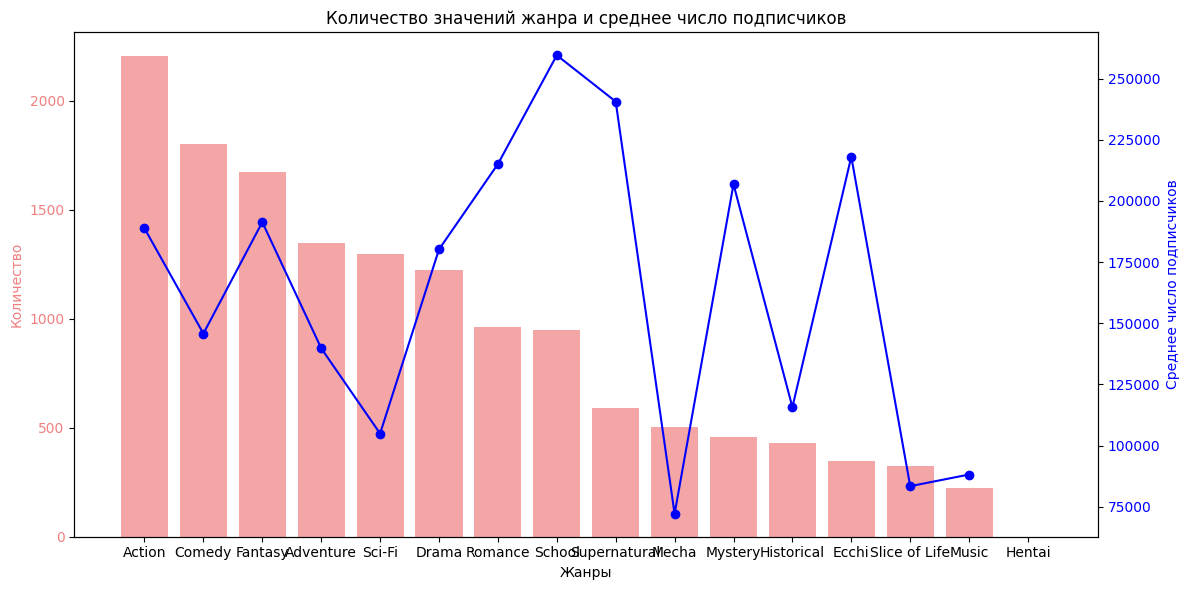

In [41]:
def count_genre(row, genre):
    return 1 if genre in row else 0

# Применяем функцию для каждого жанра из GENRE_LIST
for genre in GENRE_LIST:
    df_cleaned[genre] = df_cleaned['genres'].apply(lambda x: count_genre(x, genre))

# 1. Подсчитываем количество значений для каждого жанра
genre_counts = df_cleaned[GENRE_LIST].sum()

# 2. Рассчитываем средний рейтинг для каждого жанра
genre_avg_members = df_cleaned[GENRE_LIST].multiply(df_cleaned['members'], axis=0).sum() / genre_counts

# Создаем DataFrame для удобства отображения
genre_stats = pd.DataFrame({
    'count': genre_counts,
    'avg_members': genre_avg_members
}).sort_values(by='count', ascending=False)

# Строим график с двумя осями Y
fig, ax1 = plt.subplots(figsize=(12, 6))

# Гистограмма для количества жанров
ax1.bar(genre_stats.index, genre_stats['count'], color='lightcoral', label='Количество', alpha=0.7)
ax1.set_xlabel('Жанры')
ax1.set_ylabel('Количество', color='lightcoral')
ax1.tick_params(axis='y', labelcolor='lightcoral')

# Создаем вторую ось Y для среднего рейтинга
ax2 = ax1.twinx()
ax2.plot(genre_stats.index, genre_stats['avg_members'], color='blue', marker='o', label='Среднее число подписчиков')
ax2.set_ylabel('Среднее число подписчиков', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Заголовок графика
plt.title('Количество значений жанра и среднее число подписчиков')

# Поворот подписей на оси X для удобства чтения
plt.xticks(rotation=90)

# Показываем график
plt.tight_layout()
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_14012\403128473.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[genre] = df_cleaned['genres'].apply(lambda x: count_genre(x, genre))


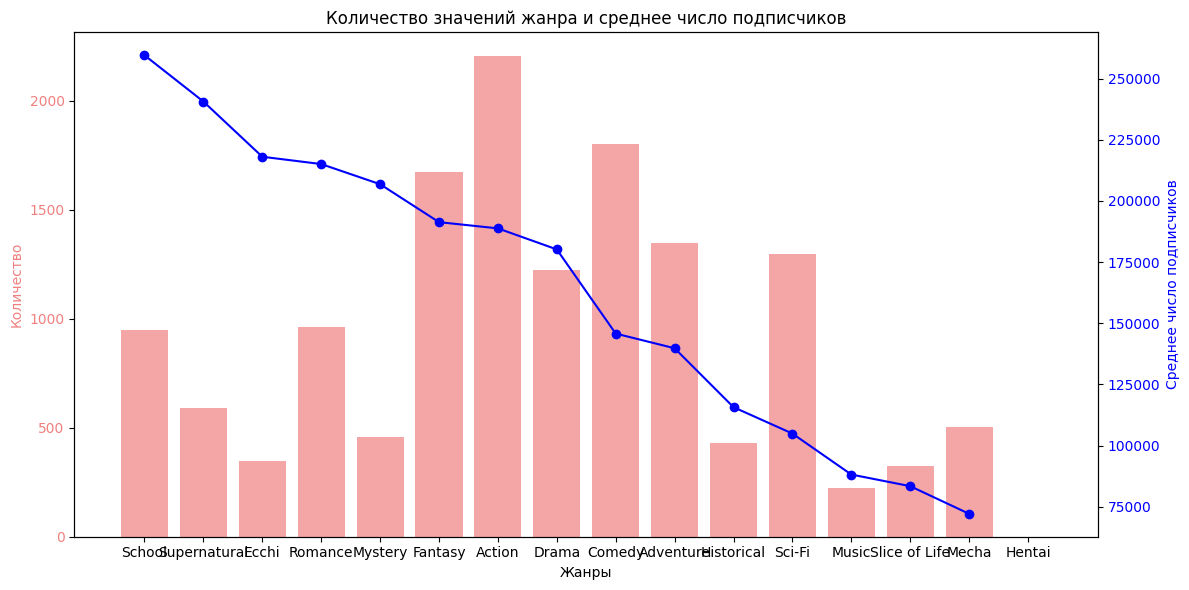

In [42]:
def count_genre(row, genre):
    return 1 if genre in row else 0

# Применяем функцию для каждого жанра из GENRE_LIST
for genre in GENRE_LIST:
    df_cleaned[genre] = df_cleaned['genres'].apply(lambda x: count_genre(x, genre))

# 1. Подсчитываем количество значений для каждого жанра
genre_counts = df_cleaned[GENRE_LIST].sum()

# 2. Рассчитываем средний рейтинг для каждого жанра
genre_avg_members = df_cleaned[GENRE_LIST].multiply(df_cleaned['members'], axis=0).sum() / genre_counts

# Создаем DataFrame для удобства отображения
genre_stats = pd.DataFrame({
    'count': genre_counts,
    'avg_members': genre_avg_members
}).sort_values(by='avg_members', ascending=False)

# Строим график с двумя осями Y
fig, ax1 = plt.subplots(figsize=(12, 6))

# Гистограмма для количества жанров
ax1.bar(genre_stats.index, genre_stats['count'], color='lightcoral', label='Количество', alpha=0.7)
ax1.set_xlabel('Жанры')
ax1.set_ylabel('Количество', color='lightcoral')
ax1.tick_params(axis='y', labelcolor='lightcoral')

# Создаем вторую ось Y для среднего рейтинга
ax2 = ax1.twinx()
ax2.plot(genre_stats.index, genre_stats['avg_members'], color='blue', marker='o', label='Среднее число подписчиков')
ax2.set_ylabel('Среднее число подписчиков', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Заголовок графика
plt.title('Количество значений жанра и среднее число подписчиков')

# Поворот подписей на оси X для удобства чтения
plt.xticks(rotation=90)

# Показываем график
plt.tight_layout()
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_14012\770991444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[dem] = df_cleaned['genres'].apply(lambda x: count_demographic(x, dem))


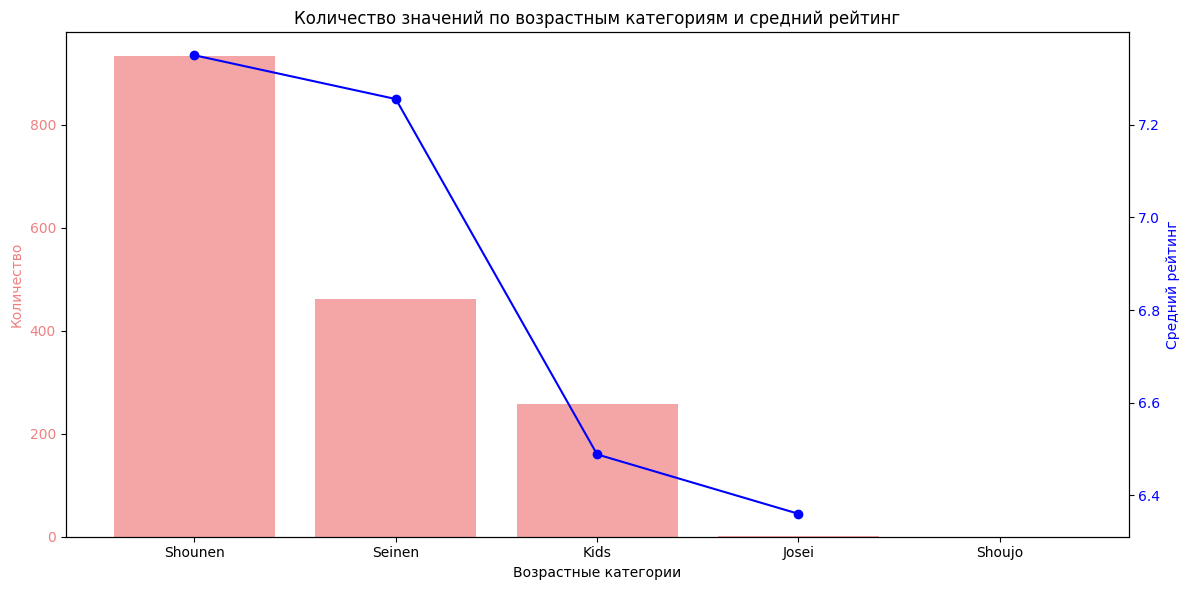

In [43]:
def count_demographic(row, dem):
    return 1 if dem in row else 0

# Применяем функцию для каждого жанра из GENRE_LIST
for dem in DEMOGRAPHIC:
    df_cleaned[dem] = df_cleaned['genres'].apply(lambda x: count_demographic(x, dem))

# 1. Подсчитываем количество значений для каждого жанра
dem_counts = df_cleaned[DEMOGRAPHIC].sum()

# 2. Рассчитываем средний рейтинг для каждого жанра
dem_avg_ratings = df_cleaned[DEMOGRAPHIC].multiply(df_cleaned['rating'], axis=0).sum() / dem_counts

# Создаем DataFrame для удобства отображения
dem_stats = pd.DataFrame({
    'count': dem_counts,
    'avg_rating': dem_avg_ratings
}).sort_values(by='count', ascending=False)

# Строим график с двумя осями Y
fig, ax1 = plt.subplots(figsize=(12, 6))

# Гистограмма для количества жанров
ax1.bar(dem_stats.index, dem_stats['count'], color='lightcoral', label='Количество', alpha=0.7)
ax1.set_xlabel('Возрастные категории')
ax1.set_ylabel('Количество', color='lightcoral')
ax1.tick_params(axis='y', labelcolor='lightcoral')

# Создаем вторую ось Y для среднего рейтинга
ax2 = ax1.twinx()
ax2.plot(dem_stats.index, dem_stats['avg_rating'], color='blue', marker='o', label='Средний рейтинг')
ax2.set_ylabel('Средний рейтинг', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Заголовок графика
plt.title('Количество значений по возрастным категориям и средний рейтинг')

# Поворот подписей на оси X для удобства чтения
plt.xticks(rotation=90)

# Показываем график
plt.tight_layout()
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_14012\2525302869.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[dem] = df_cleaned['genres'].apply(lambda x: count_demographic(x, dem))


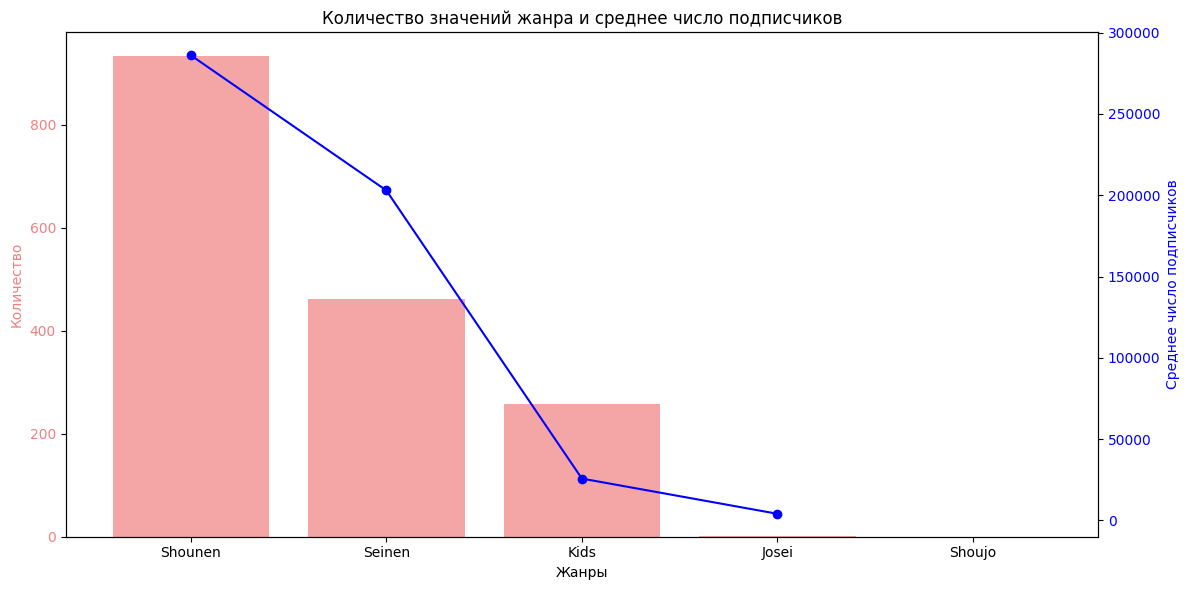

In [44]:
def count_demographic(row, dem):
    return 1 if dem in row else 0

# Применяем функцию для каждого жанра из GENRE_LIST
for dem in DEMOGRAPHIC:
    def count_demographic(row, dem):
        return 1 if dem in row else 0

# Применяем функцию для каждого жанра из GENRE_LIST
for dem in DEMOGRAPHIC:
    df_cleaned[dem] = df_cleaned['genres'].apply(lambda x: count_demographic(x, dem))

# 1. Подсчитываем количество значений для каждого жанра
dem_counts = df_cleaned[DEMOGRAPHIC].sum()

# 2. Рассчитываем средний рейтинг для каждого жанра
dem_avg_members = df_cleaned[DEMOGRAPHIC].multiply(df_cleaned['members'], axis=0).sum() / dem_counts

# Создаем DataFrame для удобства отображения
dem_stats = pd.DataFrame({
    'count': dem_counts,
    'avg_members': dem_avg_members
}).sort_values(by='count', ascending=False)

# Строим график с двумя осями Y
fig, ax1 = plt.subplots(figsize=(12, 6))

# Гистограмма для количества жанров
ax1.bar(dem_stats.index, dem_stats['count'], color='lightcoral', label='Количество', alpha=0.7)
ax1.set_xlabel('Жанры')
ax1.set_ylabel('Количество', color='lightcoral')
ax1.tick_params(axis='y', labelcolor='lightcoral')

# Создаем вторую ось Y для среднего рейтинга
ax2 = ax1.twinx()
ax2.plot(dem_stats.index, dem_stats['avg_members'], color='blue', marker='o', label='Среднее число подписчиков')
ax2.set_ylabel('Среднее число подписчиков', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Заголовок графика
plt.title('Количество значений жанра и среднее число подписчиков')

# Поворот подписей на оси X для удобства чтения
plt.xticks(rotation=90)

# Показываем график
plt.tight_layout()
plt.show()

In [45]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5407 entries, 371 to 25749
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   members             5407 non-null   int64  
 1   rating              5407 non-null   float64
 2   ranked              5407 non-null   float64
 3   popularity          5407 non-null   int64  
 4   title_orig          5407 non-null   object 
 5   genres              5407 non-null   object 
 6   description         5407 non-null   object 
 7   year                5407 non-null   float64
 8   description_length  5407 non-null   int64  
 9   Action              5407 non-null   int64  
 10  Adventure           5407 non-null   int64  
 11  Comedy              5407 non-null   int64  
 12  Drama               5407 non-null   int64  
 13  Ecchi               5407 non-null   int64  
 14  Fantasy             5407 non-null   int64  
 15  Hentai              5407 non-null   int64  
 16  Historic

In [46]:
# Убедимся, что в столбце 'year' только числа (попробуем привести к числовому типу)
df_cleaned['year'] = pd.to_numeric(df_cleaned['year'], errors='coerce')  # Преобразуем в числовой тип, заменяя ошибки на NaN

# Удалим строки с NaN в столбце 'year', чтобы они не влияли на вычисления
df_cleaned = df_cleaned.dropna(subset=['year'])

# Создаем столбцы для каждого жанра (бинарные значения, 1 если жанр присутствует, 0 если нет)
for genre in GENRE_LIST:
    df_cleaned[genre] = df_cleaned['genres'].apply(lambda x: 1 if genre in x else 0)

# Вычисляем средневзвешенный год для каждого жанра
genre_weighted_years = {}

for genre in GENRE_LIST:
    total_films = df_cleaned[genre].sum()  # Суммируем количество фильмов для жанра
    if total_films > 0:
        # Средневзвешенный год: (сумма (year * количество фильмов)) / общее количество фильмов
        weighted_year = (df_cleaned['year'] * df_cleaned[genre]).sum() / total_films
        genre_weighted_years[genre] = weighted_year
    else:
        genre_weighted_years[genre] = None  # Если для жанра нет фильмов, ставим None

# Выводим результат
for genre, weighted_year in genre_weighted_years.items():
    print(f"Средневзвешенный год для жанра {genre}: {weighted_year:.2f}" if weighted_year is not None else f"Для жанра {genre} нет данных.")

Средневзвешенный год для жанра Action: 2008.64
Средневзвешенный год для жанра Adventure: 2004.67
Средневзвешенный год для жанра Comedy: 2008.47
Средневзвешенный год для жанра Drama: 2006.09
Средневзвешенный год для жанра Ecchi: 2009.80
Средневзвешенный год для жанра Fantasy: 2010.73
Для жанра Hentai нет данных.
Средневзвешенный год для жанра Historical: 2006.76
Средневзвешенный год для жанра Mecha: 2001.33
Средневзвешенный год для жанра Music: 2012.61
Средневзвешенный год для жанра Mystery: 2010.68
Средневзвешенный год для жанра Romance: 2008.79
Средневзвешенный год для жанра School: 2012.73
Средневзвешенный год для жанра Sci-Fi: 2004.14
Средневзвешенный год для жанра Slice of Life: 2011.78
Средневзвешенный год для жанра Supernatural: 2010.81


C:\Users\andre\AppData\Local\Temp\ipykernel_14012\1412830032.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['year'] = pd.to_numeric(df_cleaned['year'], errors='coerce')  # Преобразуем в числовой тип, заменяя ошибки на NaN


In [47]:
genre_weighted_years

{'Action': np.float64(2008.6377666817975),
 'Adventure': np.float64(2004.6723498888066),
 'Comedy': np.float64(2008.4711111111112),
 'Drama': np.float64(2006.0941850941851),
 'Ecchi': np.float64(2009.8040345821325),
 'Fantasy': np.float64(2010.726838015541),
 'Hentai': None,
 'Historical': np.float64(2006.7581395348836),
 'Mecha': np.float64(2001.332669322709),
 'Music': np.float64(2012.611607142857),
 'Mystery': np.float64(2010.681917211329),
 'Romance': np.float64(2008.7918834547347),
 'School': np.float64(2012.732349841939),
 'Sci-Fi': np.float64(2004.1366795366796),
 'Slice of Life': np.float64(2011.7846153846153),
 'Supernatural': np.float64(2010.806779661017)}

In [48]:
genre_weighted_ratings

Action           6.936813
Adventure        6.919918
Comedy           6.942278
Drama            7.181507
Ecchi            6.621758
Fantasy          6.948022
Hentai                NaN
Historical       7.076233
Mecha            6.783327
Music            6.983125
Mystery          7.274706
Romance          7.071686
School           7.124415
Sci-Fi           6.818873
Slice of Life    7.044092
Supernatural     7.119678
dtype: float64

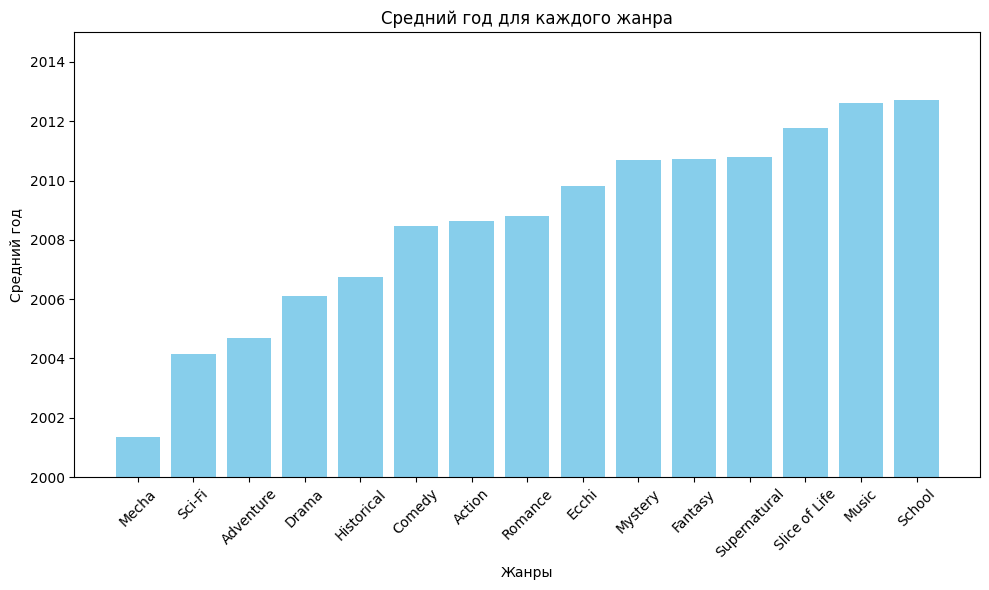

In [49]:
# Фильтруем жанры с None значением
filtered_genre_weighted_years = {genre: year for genre, year in genre_weighted_years.items() if year is not None}

# Сортируем по средневзвешенному году
sorted_genre_weighted_years = dict(sorted(filtered_genre_weighted_years.items(), key=lambda item: item[1]))

# Строим график
plt.figure(figsize=(10, 6))

# Столбчатая диаграмма для средневзвешенных годов
plt.bar(sorted_genre_weighted_years.keys(), sorted_genre_weighted_years.values(), color='skyblue')

# Настройки графика
plt.title('Средний год для каждого жанра')
plt.xlabel('Жанры')
plt.ylabel('Средний год')
plt.xticks(rotation=45)

# Ограничиваем ось Y от 2000 до 2015
plt.ylim(2000, 2015)

# Отображение графика
plt.tight_layout()
plt.show()

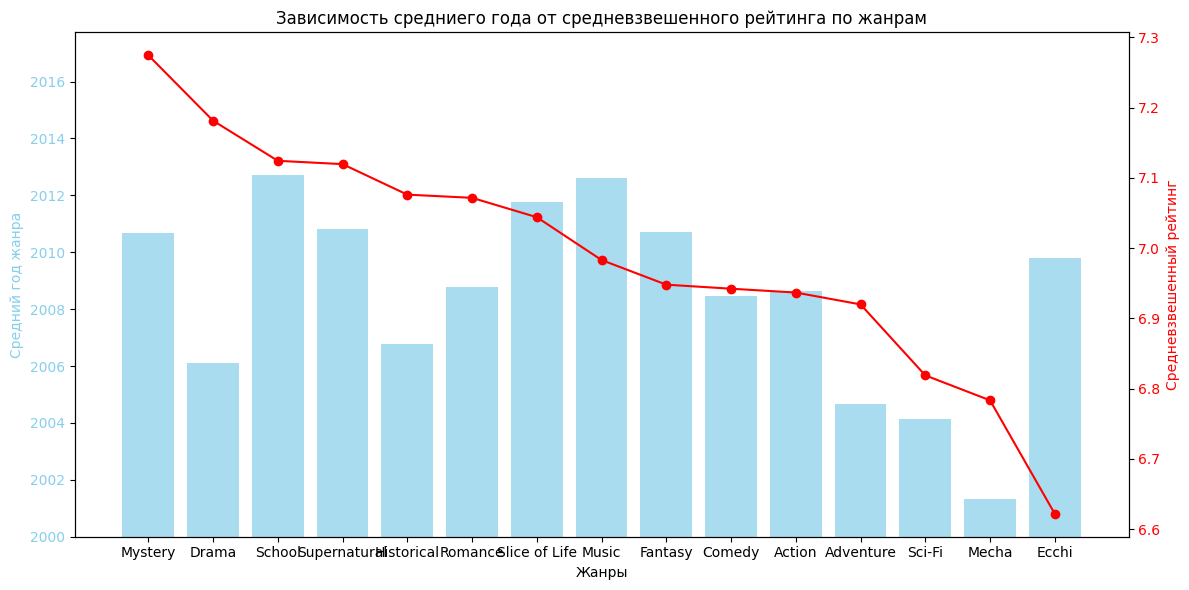

In [50]:
# Преобразуем значения словарей в стандартные float (скаляры)
genre_weighted_years = {k: float(v) if v is not None else None for k, v in genre_weighted_years.items()}
genre_weighted_ratings = {k: float(v) if v is not None else None for k, v in genre_weighted_ratings.items()}

# Создаем DataFrame для обработки данных
data = pd.DataFrame({
    'Genre': list(genre_weighted_years.keys()),
    'Weighted_Year': list(genre_weighted_years.values()),
    'Weighted_Rating': list(genre_weighted_ratings.values())
})

# Удаляем строки с отсутствующими данными
data = data.dropna()

# Сортируем по убыванию средневзвешенного рейтинга
data = data.sort_values(by='Weighted_Rating', ascending=False)

# Построение графика
fig, ax1 = plt.subplots(figsize=(12, 6))

# Первая ось Y (для годов)
ax1.bar(data['Genre'], data['Weighted_Year'], color='skyblue', label='Средний год жанра', alpha=0.7)
ax1.set_xlabel('Жанры')
ax1.set_ylabel('Средний год жанра', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_ylim(2000, max(data['Weighted_Year']) + 5)  # Устанавливаем нижнюю границу 2000

# Вторая ось Y (для рейтингов)
ax2 = ax1.twinx()
ax2.plot(data['Genre'], data['Weighted_Rating'], color='red', marker='o', label='Средневзвешенный рейтинг')
ax2.set_ylabel('Средневзвешенный рейтинг', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Настройка графика
plt.title('Зависимость средниего года от средневзвешенного рейтинга по жанрам')
plt.xticks(rotation=90)

# Показываем график
fig.tight_layout()
plt.show()

In [51]:
# Заменяем пропущенные значения в столбце 'genres' на пустую строку
df_selected['genres'] = df_selected['genres'].fillna('')

# Применяем обработку для демографических категорий
for dem in DEMOGRAPHIC:
    df_selected[dem] = df_selected['genres'].apply(lambda x: 1 if dem in x else 0)

# Подсчитываем количество вхождений для каждой категории
dem_counts = df_selected[DEMOGRAPHIC].sum()

# Вывод распределения
print("Распределение по возрастным категориям:")
print(dem_counts)

Распределение по возрастным категориям:
Josei        26
Kids       6185
Seinen      999
Shoujo      185
Shounen    1911
dtype: int64


C:\Users\andre\AppData\Local\Temp\ipykernel_14012\1975733679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['genres'] = df_selected['genres'].fillna('')
C:\Users\andre\AppData\Local\Temp\ipykernel_14012\1975733679.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[dem] = df_selected['genres'].apply(lambda x: 1 if dem in x else 0)
C:\Users\andre\AppData\Local\Temp\ipykernel_14012\1975733679.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [52]:
# Заменяем пропущенные значения в столбце 'genres' на пустую строку
df_cl['genres'] = df_cl['genres'].fillna('')

# Применяем обработку для демографических категорий
for dem in DEMOGRAPHIC:
    df_cl[dem] = df_cl['genres'].apply(lambda x: 1 if dem in x else 0)

# Подсчитываем количество вхождений для каждой категории
dem_counts = df_cl[DEMOGRAPHIC].sum()

# Вывод распределения
print("Распределение по возрастным категориям:")
print(dem_counts)

Распределение по возрастным категориям:
Josei        20
Kids       1042
Seinen      890
Shoujo      105
Shounen    1759
dtype: int64


C:\Users\andre\AppData\Local\Temp\ipykernel_14012\3410802286.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cl['genres'] = df_cl['genres'].fillna('')
C:\Users\andre\AppData\Local\Temp\ipykernel_14012\3410802286.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cl[dem] = df_cl['genres'].apply(lambda x: 1 if dem in x else 0)
C:\Users\andre\AppData\Local\Temp\ipykernel_14012\3410802286.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [53]:
# Заменяем пропущенные значения в столбце 'genres' на пустую строку
df_cleaned['genres'] = df_cleaned['genres'].fillna('')

# Применяем обработку для демографических категорий
for dem in DEMOGRAPHIC:
    df_cleaned[dem] = df_cleaned['genres'].apply(lambda x: 1 if dem in x else 0)

# Подсчитываем количество вхождений для каждой категории
dem_counts = df_cleaned[DEMOGRAPHIC].sum()

# Вывод распределения
print("Распределение по возрастным категориям:")
print(dem_counts)

Распределение по возрастным категориям:
Josei        1
Kids       257
Seinen     461
Shoujo       0
Shounen    933
dtype: int64


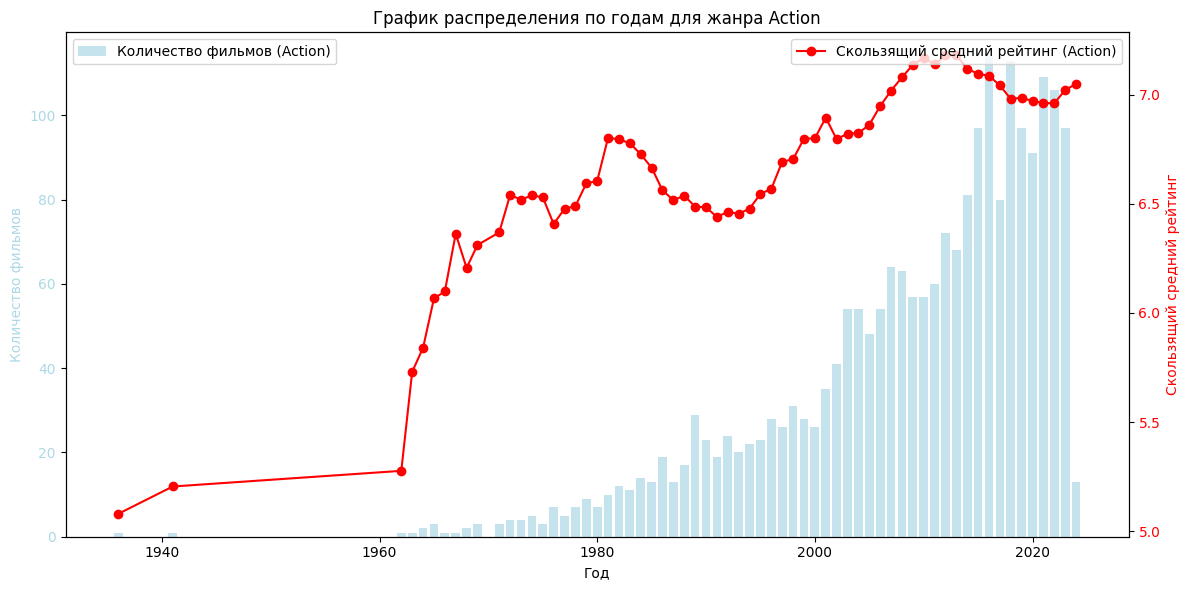

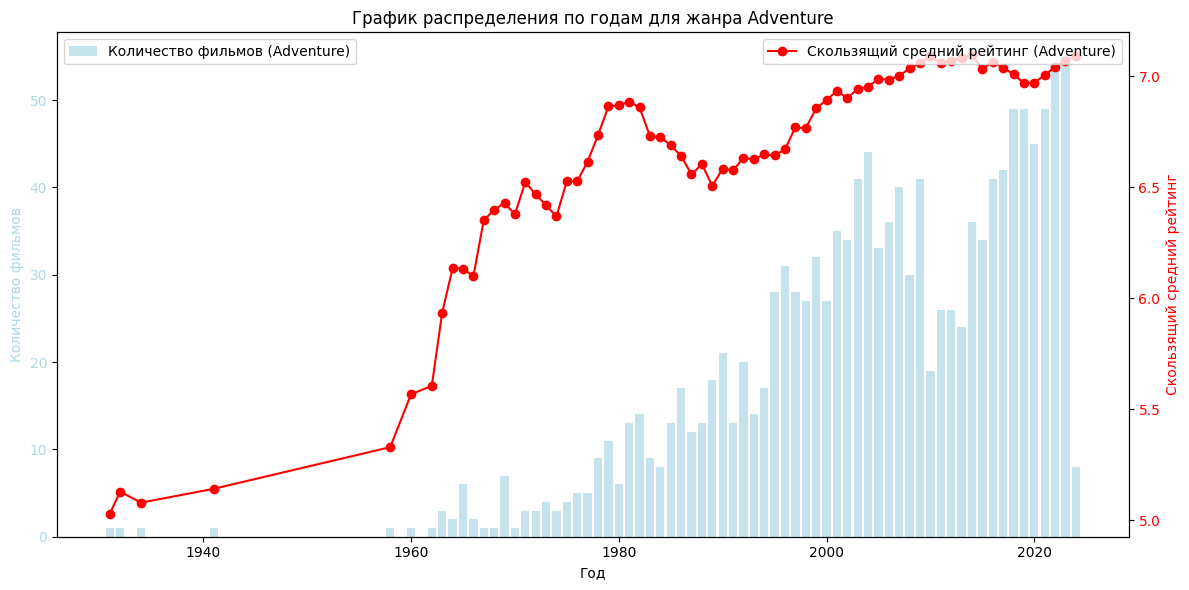

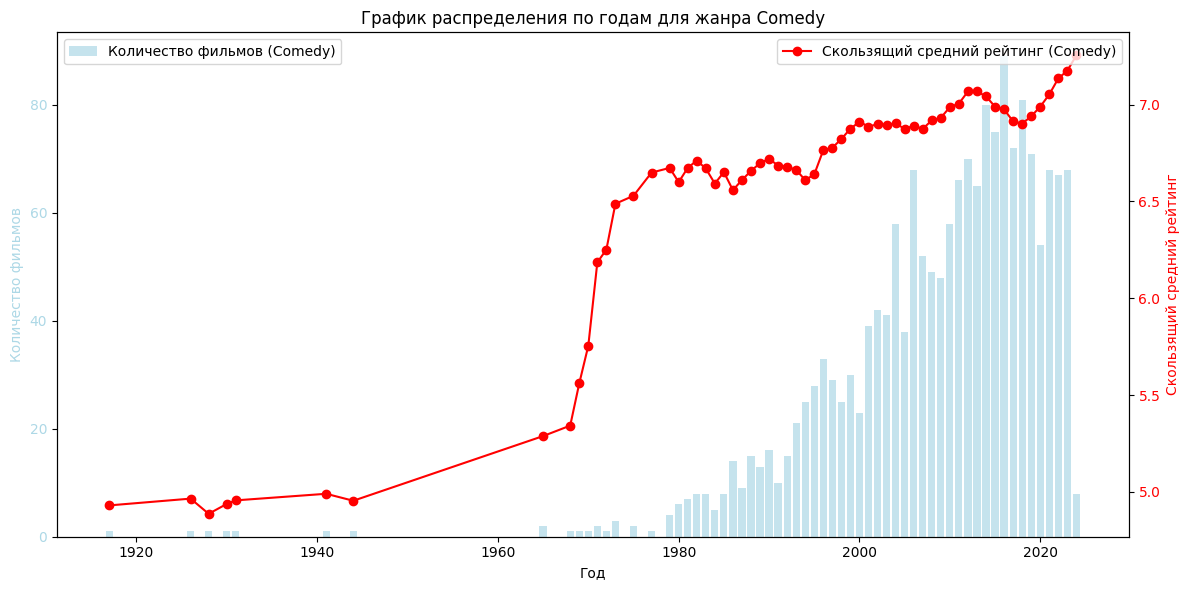

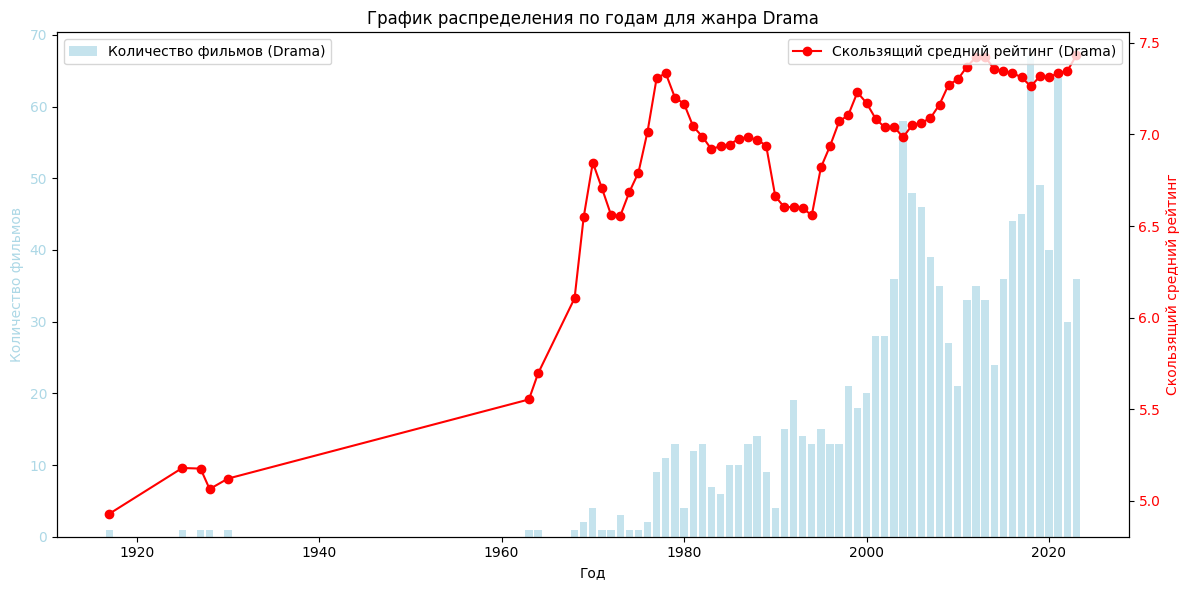

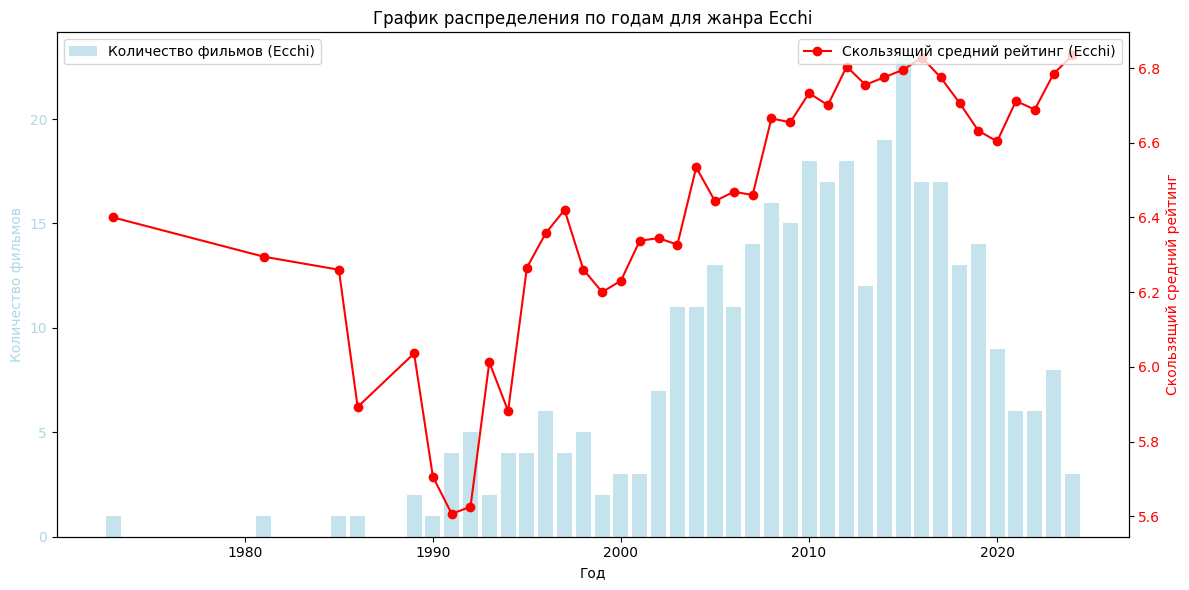

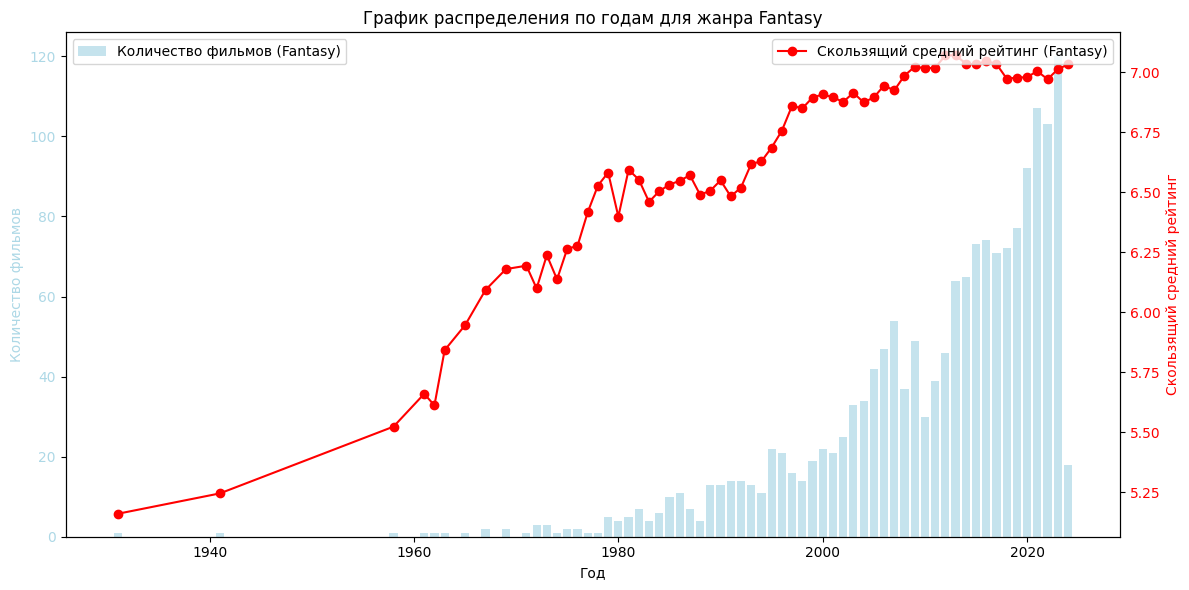

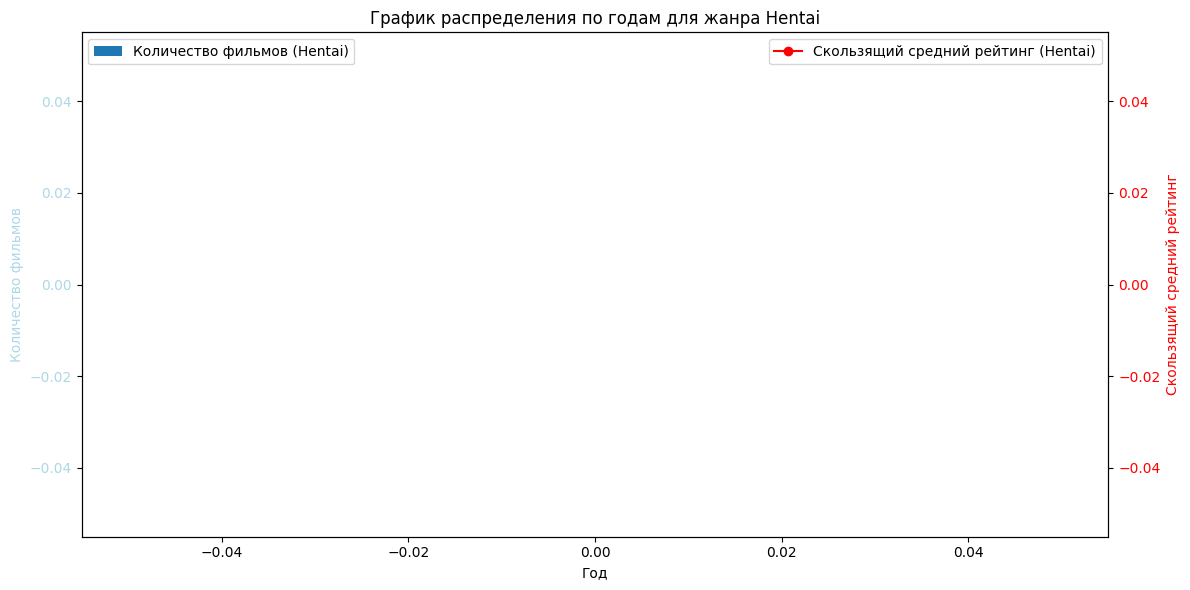

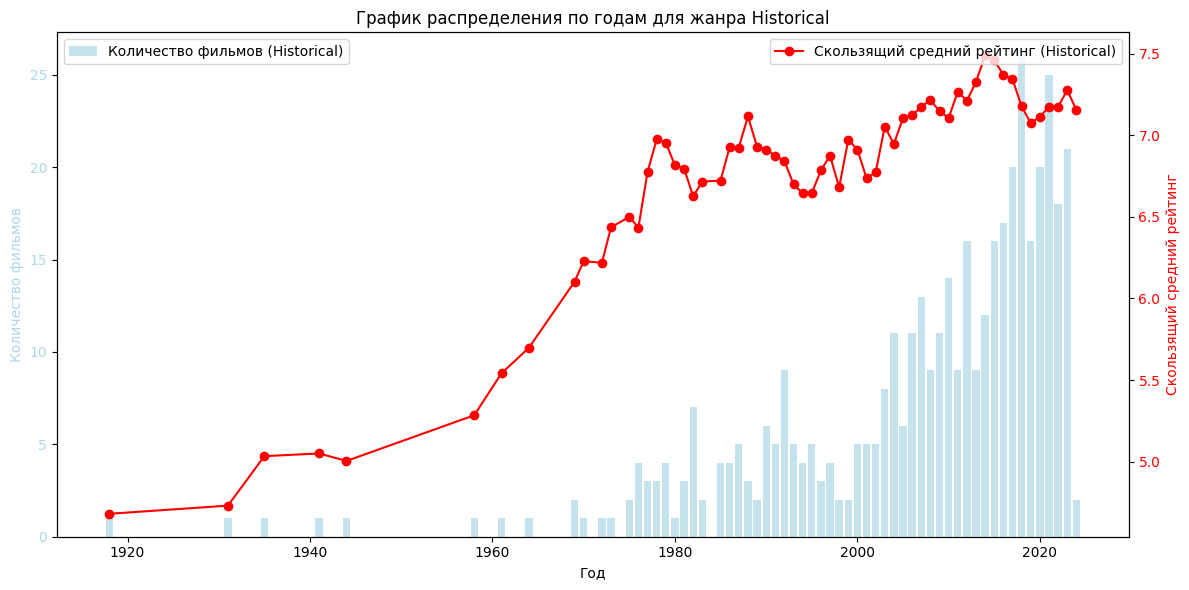

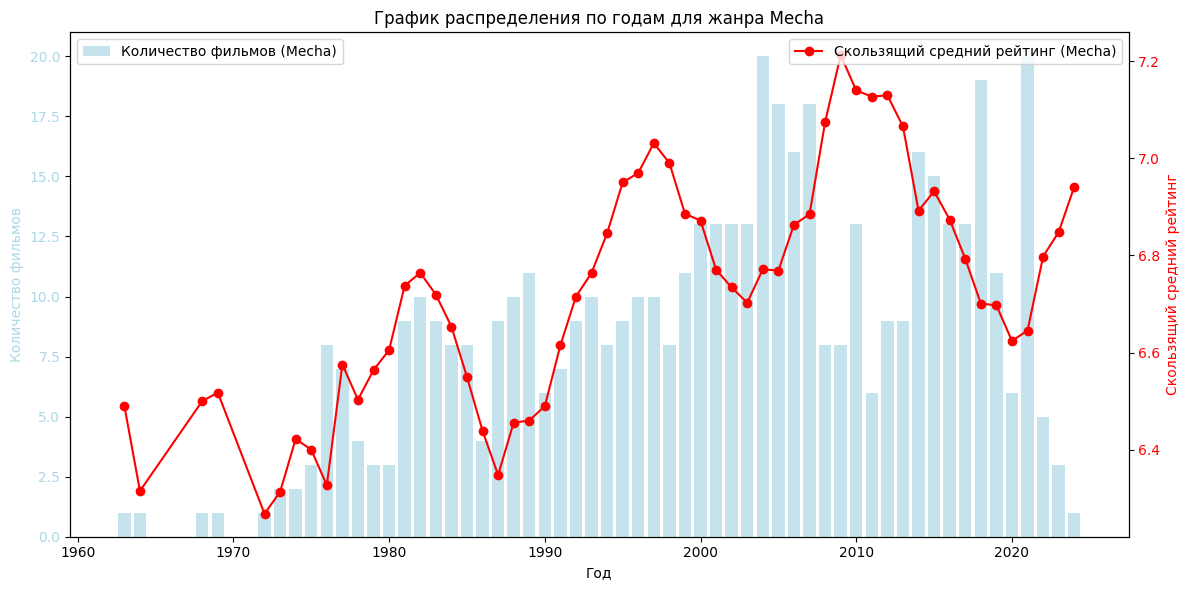

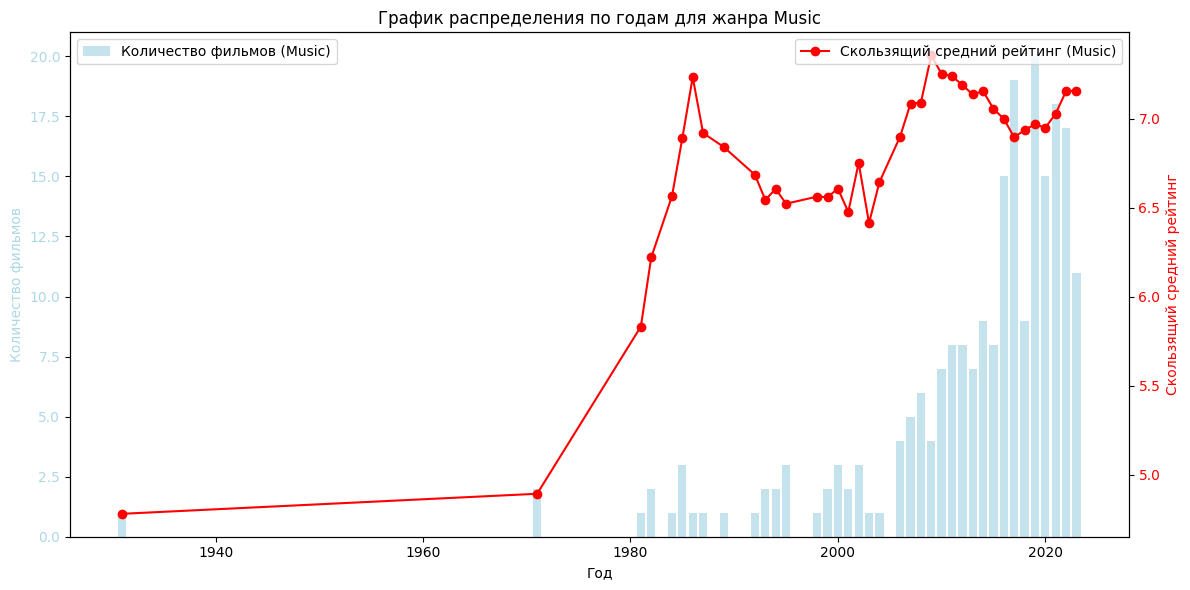

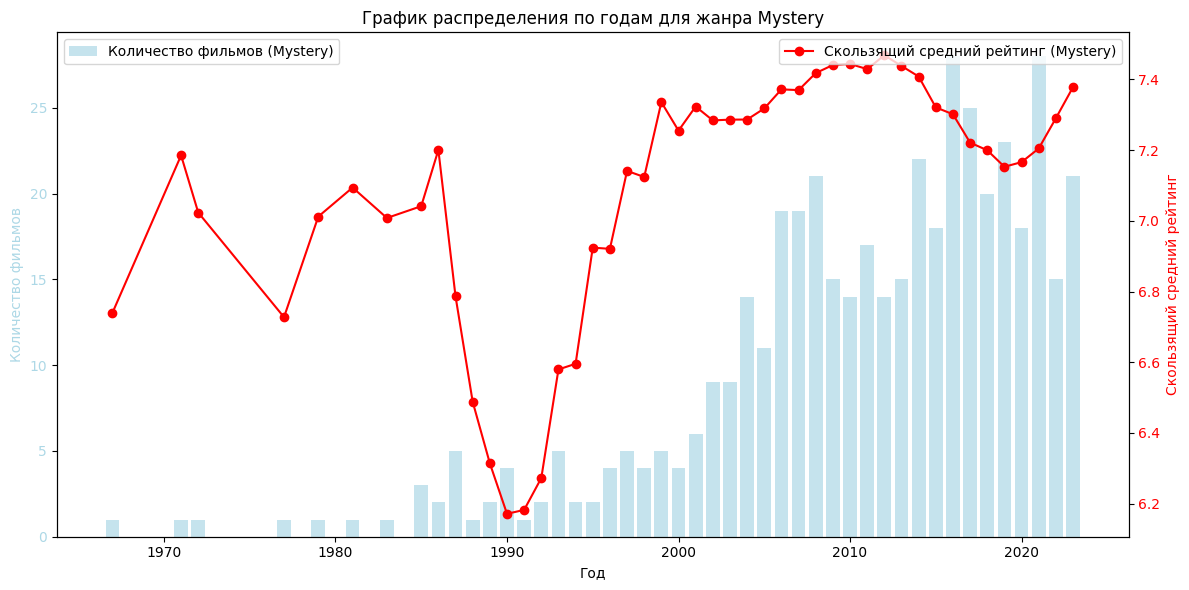

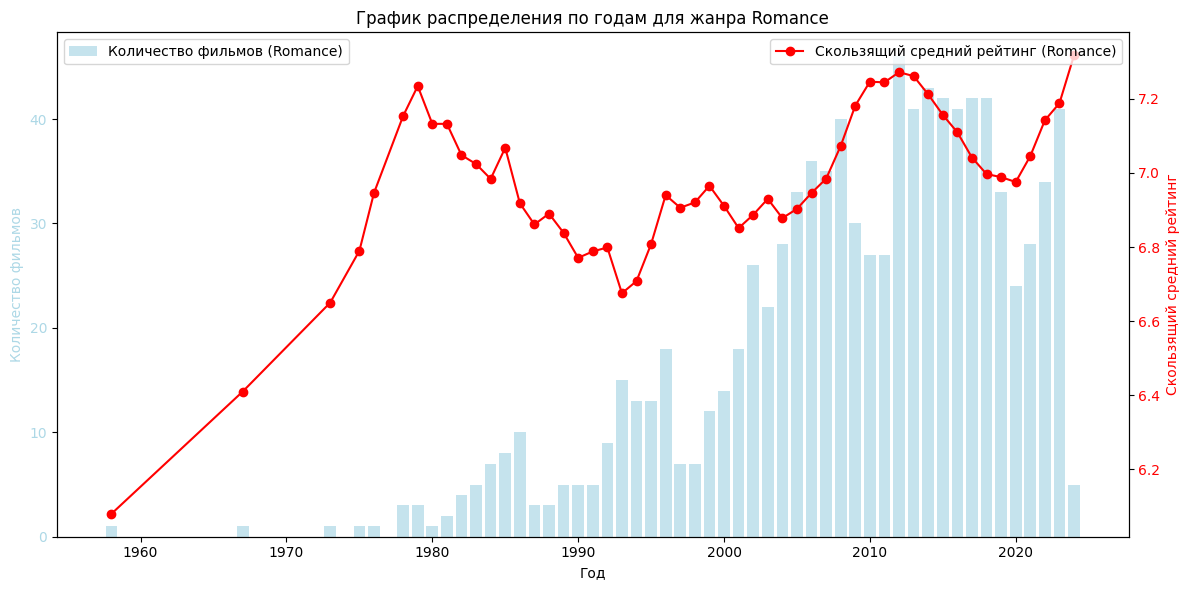

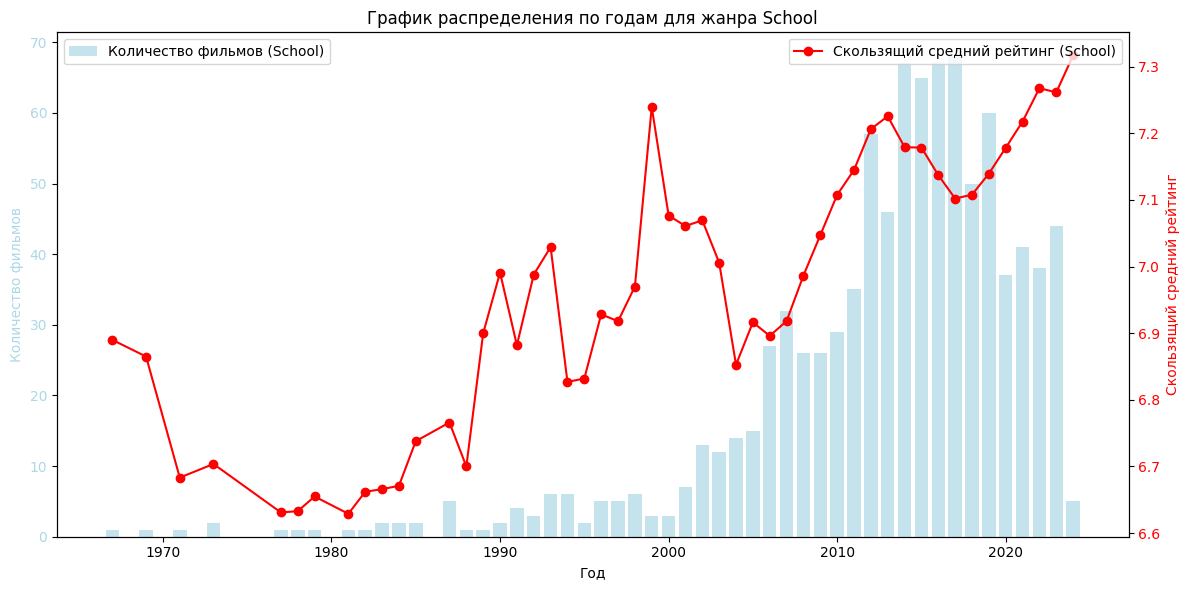

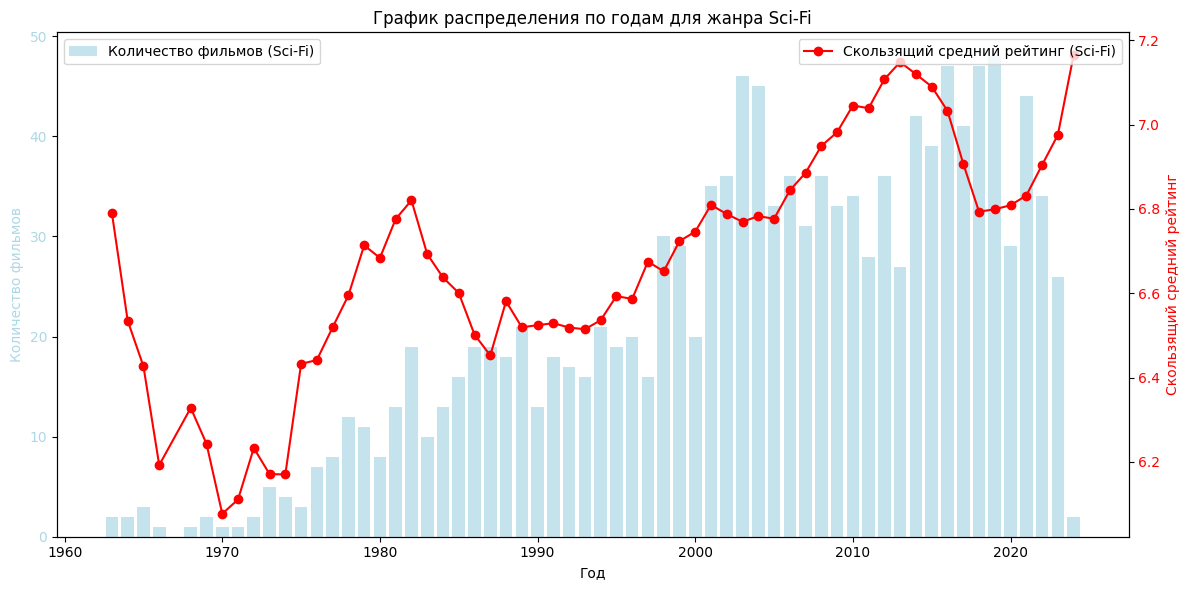

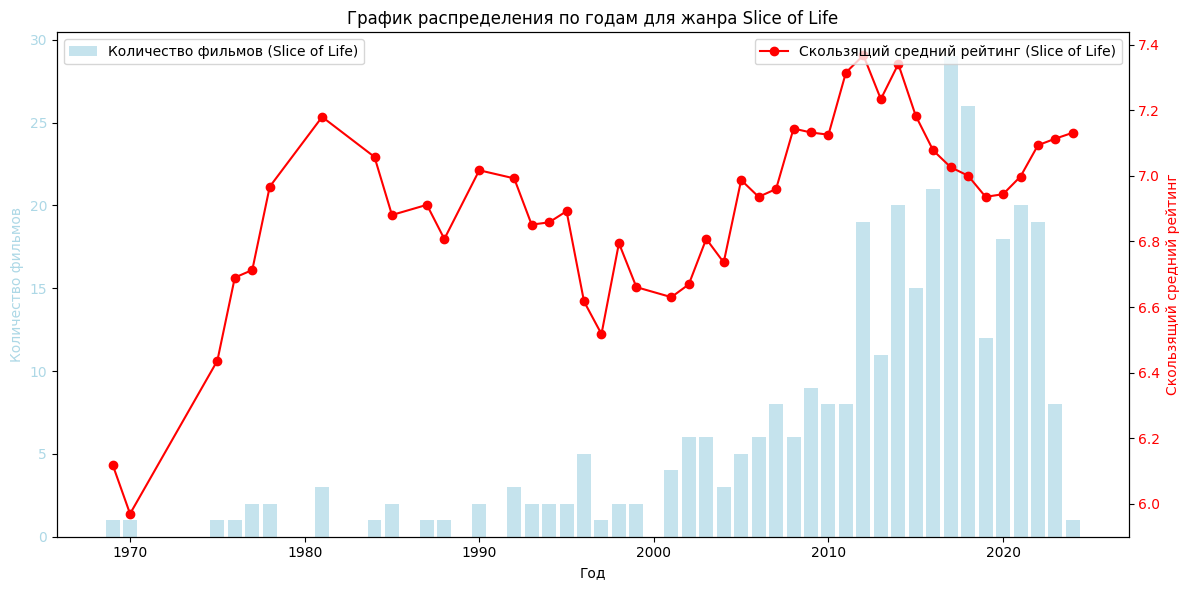

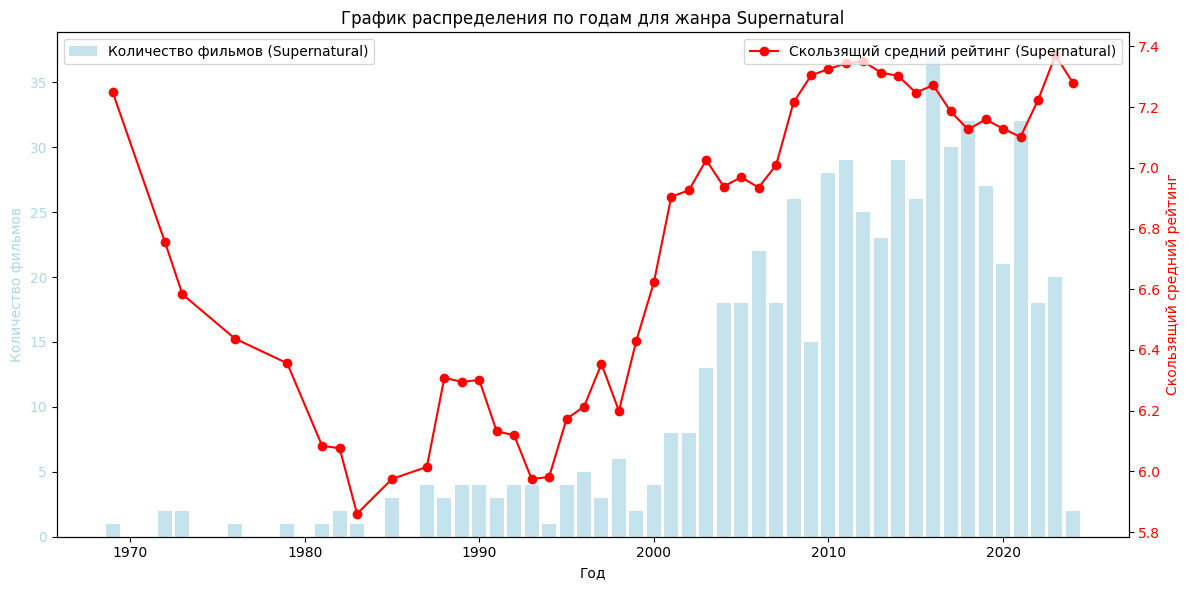

In [54]:
# Убедимся, что год и оценка имеют правильный формат
df_cleaned['year'] = pd.to_numeric(df_cleaned['year'], errors='coerce')  # Преобразуем год в числовой тип
df_cleaned['rating'] = pd.to_numeric(df_cleaned['rating'], errors='coerce')  # Преобразуем рейтинг в числовой тип

# Для каждого жанра строим графики
for genre in GENRE_LIST:
    # Фильтруем данные по жанру
    df_genre = df_cleaned[df_cleaned['genres'].str.contains(genre, case=False, na=False)]
    
    # Подсчитываем количество фильмов по годам
    movie_counts = df_genre.groupby('year').size()
    
    # Рассчитываем скользящее среднее для рейтинга по годам
    avg_ratings = df_genre.groupby('year')['rating'].mean().rolling(window=5, min_periods=1).mean()  # Скользящее среднее

    # Создаем фигуру и оси
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Строим количество фильмов по годам
    ax1.bar(movie_counts.index, movie_counts.values, color='lightblue', label=f'Количество фильмов ({genre})', alpha=0.7)
    ax1.set_xlabel('Год')
    ax1.set_ylabel('Количество фильмов', color='lightblue')
    ax1.tick_params(axis='y', labelcolor='lightblue')

    # Создаем вторую ось Y для скользящего среднего рейтинга
    ax2 = ax1.twinx()
    ax2.plot(avg_ratings.index, avg_ratings.values, color='red', marker='o', label=f'Скользящий средний рейтинг ({genre})')
    ax2.set_ylabel('Скользящий средний рейтинг', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Заголовок графика
    plt.title(f'График распределения по годам для жанра {genre}')

    # Поворот подписей на оси X для удобства чтения
    plt.xticks(rotation=45)

    # Показываем легенду
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Показываем график
    plt.tight_layout()
    plt.show()

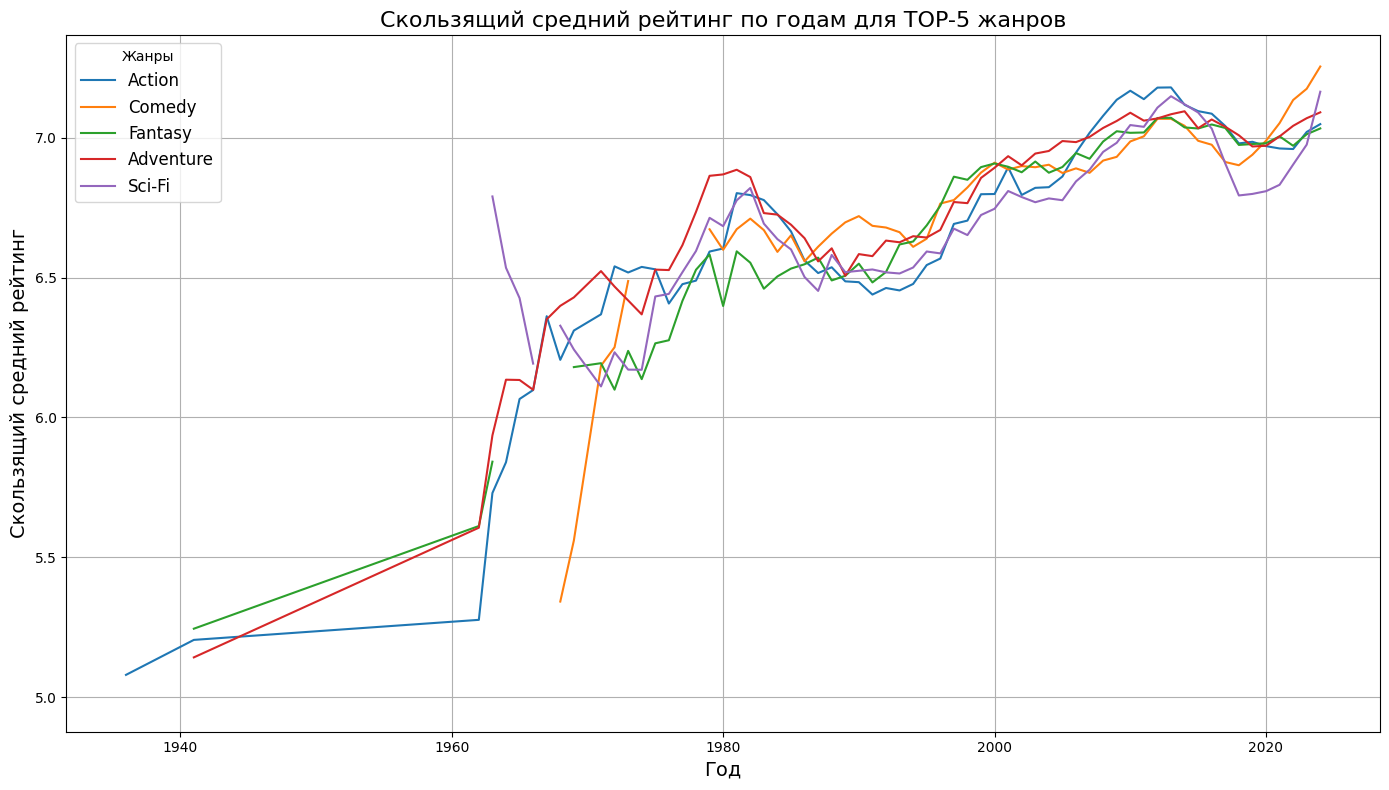

In [55]:
TOP_5_GENRES = ['Action', 'Comedy', 'Fantasy', 'Adventure', 'Sci-Fi']
# Убедимся, что год и оценка имеют правильный формат
df_cleaned['year'] = pd.to_numeric(df_cleaned['year'], errors='coerce')  # Преобразуем год в числовой тип
df_cleaned['rating'] = pd.to_numeric(df_cleaned['rating'], errors='coerce')  # Преобразуем рейтинг в числовой тип

# Список жанров
TOP_5_GENRES = ['Action', 'Comedy', 'Fantasy', 'Adventure', 'Sci-Fi']

# Создаем пустой DataFrame для хранения скользящих средних рейтингов
rolling_ratings = pd.DataFrame()

# Рассчитываем скользящее среднее для каждого жанра
for genre in TOP_5_GENRES:
    # Фильтруем данные по жанру
    df_genre = df_cleaned[df_cleaned['genres'].str.contains(genre, case=False, na=False)]
    
    # Группируем по годам и рассчитываем средний рейтинг
    avg_ratings = df_genre.groupby('year')['rating'].mean()
    
    # Вычисляем скользящее среднее с окном в 5 лет
    rolling_avg = avg_ratings.rolling(window=5, min_periods=1).mean()
    
    # Добавляем результаты в DataFrame
    rolling_ratings[genre] = rolling_avg

# Построение графика
plt.figure(figsize=(14, 8))

# Построим линии для каждого жанра
for genre in TOP_5_GENRES:
    plt.plot(rolling_ratings.index, rolling_ratings[genre], label=genre)

# Настройка графика
plt.title('Скользящий средний рейтинг по годам для TOP-5 жанров', fontsize=16)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Скользящий средний рейтинг', fontsize=14)
plt.legend(title="Жанры", fontsize=12)
plt.grid(True)

# Показываем график
plt.tight_layout()
plt.show()